## **Preprocessamento e Ajustes dos Dados**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


#### **IMPORT E LOAD DE DADOS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('ggplot')
# PROCESSAMENTO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# MODELOS
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
import scipy

# PREPROCESSAMENTO E METRICAS
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *

# EXPORTAÇÃO
# Lib para exportar scalers
# https://scikit-learn.org/stable/modules/model_persistence.html
from joblib import dump, load

# Lib para exportar numpy ou arrays
# https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html
import h5py

In [ ]:
df_file = "https://raw.githubusercontent.com/ddlandim/monografy-ann-demand-prediction/master/experimentos_monografia/input/Todos.csv"

df = pd.read_csv(df_file,index_col='DATA',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 514 entries, 2017-12-04 to 2019-12-16
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEMESTRE_1               514 non-null    int64  
 1   SEMESTRE_2               514 non-null    int64  
 2   SEGUNDA                  514 non-null    int64  
 3   TERCA                    514 non-null    int64  
 4   QUARTA                   514 non-null    int64  
 5   QUINTA                   514 non-null    int64  
 6   SEXTA                    514 non-null    int64  
 7   DISTANCIA_DIA_ANTERIOR   514 non-null    int64  
 8   DISTANCIA_DIA_POSTERIOR  514 non-null    int64  
 9   PERC_CONCLUSAO_SEM       514 non-null    float64
 10  PERC_CONCLUSAO_MES       514 non-null    float64
 11  PRESSAO_ATMOSFERICA      514 non-null    float64
 12  TEMPERATURA              514 non-null    float64
 13  UMIDADE                  514 non-null    int64  
 14  VENTO  

In [ ]:
# Testando lag temporal
df['ENTR_ALMOCO_1'][50] == df['ENTR_ALMOCO_2'][51]

True

#### **FUNÇÕES AUXILIARES**

In [ ]:
# plota serie
def plot_serie(serie, size=(12,4), title='Plot'):
    plt.figure(figsize=size)
    plt.title(title)
    plt.plot(serie)
    plt.show()

In [ ]:
# pega coluna dataframe['coluna_y'] e usa como y
# todas as outras colunas usa como x 
def to_supervised_numpy(dataframe, coluna_y):
    X = dataframe.loc[:, dataframe.columns != coluna_y].values # instantes de tempo passado (lags)
    Y = dataframe[coluna_y].values # valor atual para prever
    return np.array(X), np.array(Y)


In [ ]:
def plot_history(history, start_epoch=0):
    start_epoch = 10
    plt.figure(figsize=(10,4))
    plt.title('História Treino')
    plt.plot(history.history['loss'][start_epoch:], label='Train Loss')
    plt.plot(history.history['val_loss'][start_epoch:], label='Validation Loss')
    plt.legend()

In [ ]:
df_models_metrics = pd.DataFrame()
df_models_metrics['parameters'] =  ['TOTAL_PROJETADAS','TOTAL_CONSUMIDAS','TOTAL_SUBPROJETADAS','TOTAL_SUPERPROJETADAS','ERRO_ABS_MEDIO','ERRO_ABS_PER_MEDIO']

In [ ]:
def pe (row,true,predicted): # array of % error
    true = row[true]
    predicted = int(row[predicted])
    error = predicted - true
    if true == 0:
        pe = 0
    else:
        pe = abs(error/true)
    return pe,error

def mape (_df,x,y): # mean of array of % error
    df = pd.DataFrame()
    df = _df
    arr_pe = [0,0]
    arr_pe = df.apply(lambda row: pe(row,x,y), axis=1)
    return np.mean(arr_pe[0])*100 , arr_pe[1]

def avaliacao_predicoes (_df,true,pred,df_models_metrics):
    df = pd.DataFrame()
    df = _df
    arr_true = df[true]
    arr_pred = df[pred]
    m_r, m_p = scipy.stats.pearsonr(arr_true, arr_pred)
    print("CORRELAÇÃO (r): " + str(m_r) + " Pi (p) :" + str(m_p))
    sns.regplot(x=arr_true,y=arr_pred,data=df)
    rmse = mean_squared_error(arr_true, arr_pred, squared=False)
    print("RMSE = " + str(rmse))
    arr_e = []
    arr_pe = []
    #m_mape,arr_e = mape(df,true,pred)
    for true_i,pred_i in zip(arr_true,arr_pred):
        arr_e += [pred_i - true_i]
        if true_i == 0:
            arr_pe += [0]
        else:
            arr_pe += [(pred_i - true_i)/true_i]
    m_mae = np.mean(np.abs(arr_e))
    m_mape = np.mean(np.abs(arr_pe))*100
    subpredictions = sum(i for i in arr_e if i < 0)
    superpredictions = sum(i for i in arr_e if i >= 0)
    print("TOTAL DE REFEIÇÕES PROJETADAS = " + str(len(arr_pred)) + " : " + str(sum(arr_pred)))
    print("TOTAL DE REFEIÇÕES CONSUMIDAS = " + str(len(arr_true)) + " : " + str(sum(arr_true)))
    print("TOTAL DE REFEIÇÕES SUB PROJETADAS = " + str(subpredictions))
    print("TOTAL DE REFEIÇÕES SUPER PROJETADAS = " + str(superpredictions))
    print("ERRO ABSOLUTO MÉDIO = " + str(m_mae))
    print("ERRO ABSOLUTO PERCENTUAL MÉDIO = " + str(m_mape)+"%")
    plt.figure(figsize=(30,5))
    df[true].plot( linewidth=1.5, color='red', label = true)
    df[pred].plot( linewidth=2.5, color='blue', label = pred)
    plt.legend()
    plt.xlabel("Index", labelpad=15)
    plt.show()
    #['TOTAL_PROJETADAS','TOTAL_CONSUMIDAS','TOTAL_SUBPROJETADAS','TOTAL_SUPERPROJETADAS','ERRO_ABS_MEDIO','ERRO_ABS_PER_MEDIO']
    #df_models_metrics.drop(columns=[pred])
    df_models_metrics[pred] = [sum(arr_pred),sum(arr_true),subpredictions,superpredictions,m_mae,m_mape]
    return m_r,m_p,rmse,m_mape,subpredictions,superpredictions

In [ ]:
def ru_pred_almoco (row,factor):
    true_5days_ago = row['ENTR_ALMOCO_5']
    predicted = int(true_5days_ago + (true_5days_ago*factor))
    return predicted

def ru_pred_jantar (row,factor):
    true_5days_ago = row['ENTR_JANTAR_5']
    predicted = int(true_5days_ago + (true_5days_ago*factor))
    return predicted

#### **SPLIT TREINO / TESTE**

In [ ]:
test_start = '2019-01-01'
validation_start = '2018-01-01'
validation_semester = 'SEMESTRE_1'

df_test = df.loc[ test_start : ]

df_split =  df.loc[ validation_start : test_start ]

df_train1 = df.loc[ : validation_start ]
df_train2 = df_split.loc[  df_split[ validation_semester ] == 0 ]
df_train = pd.concat([df_train1,df_train2])

df_val = df_split.loc[  df_split[ validation_semester ] == 1 ]

df_len = len(df)
df_split_len = len(df_split)
df_test_len = len(df_test)
df_train1_len = len(df_train1)
df_train2_len = len(df_train2)
df_train_len = len(df_train)
df_val_len = len(df_val)

assert_dfs_splits = df_len == (df_train_len + df_val_len + df_test_len)

print('Tamanho do conjunto de dados = ' + str(df_len))

print('Tamanho do conjunto de treino até o conjunto de validação = ' + str(df_train1_len) + " [ : " + validation_start + " ]")

print('Split = ' + str(df_split_len) + " [" + validation_start + " : " + test_start + " ]")

print('Tamanho da 2a parte do conjunto de treino entre o fim do conjunto de validação e o inicio do conjunto de teste = ' + str(df_train2_len) +  " [" + validation_start + " : " + test_start + '] where ' + validation_semester + " == False")
print('Tamanho do conjunto total de treino = ' + str(df_train_len))
print('Tamanho do conjunto de validação = ' + str(df_val_len) +  " [ " + validation_start + " : " + test_start + ' ] where ' + validation_semester + " == True")
print('Tamanho do conjuto de teste = ' + str(df_test_len))
if assert_dfs_splits:
  print("Divisão realizada com sucesso, a soma dos conjuntos de treino,validação e teste corresponderam ao tamanho do dataset original")
else:
  print("error in split, check the size diff above")
  print(df_train_len+df_test_len+df_test_len - df_len)

Tamanho do conjunto de dados = 514
Tamanho do conjunto de treino até o conjunto de validação = 148 [ : 2018-01-01 ]
Split = 184 [2018-01-01 : 2019-01-01 ]
Tamanho da 2a parte do conjunto de treino entre o fim do conjunto de validação e o inicio do conjunto de teste = 95 [2018-01-01 : 2019-01-01] where SEMESTRE_1 == False
Tamanho do conjunto total de treino = 243
Tamanho do conjunto de validação = 89 [ 2018-01-01 : 2019-01-01 ] where SEMESTRE_1 == True
Tamanho do conjuto de teste = 182
Divisão realizada com sucesso, a soma dos conjuntos de treino,validação e teste corresponderam ao tamanho do dataset original


In [ ]:
df_test = df_test.loc[  df_test[ validation_semester ] == 1 ]
df_test

SEMESTRE_1  SEMESTRE_2  ...  ENTR_JANTAR_4  ENTR_JANTAR_5
DATA                                ...                              
2019-02-20           1           0  ...             27             50
2019-02-21           1           0  ...             14             27
2019-02-22           1           0  ...             17             14
2019-02-25           1           0  ...              0             17
2019-02-26           1           0  ...            246              0
...                ...         ...  ...            ...            ...
2019-01-07           1           0  ...            146            157
2019-02-07           1           0  ...            129            146
2019-03-07           1           0  ...            120            129
2019-04-07           1           0  ...             20            120
2019-05-07           1           0  ...             23             20

[88 rows x 33 columns]

CORRELAÇÃO (r): 0.1593700778609433 Pi (p) :0.1380359414354423
RMSE = 224.4733989099417
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 41351
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3650
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 13039
ERRO ABSOLUTO MÉDIO = 189.64772727272728
ERRO ABSOLUTO PERCENTUAL MÉDIO = 167.27247078023487%


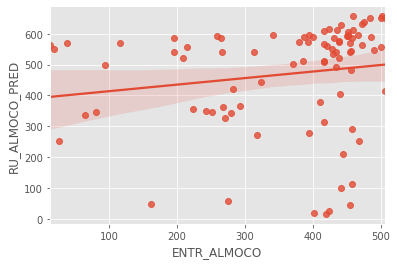

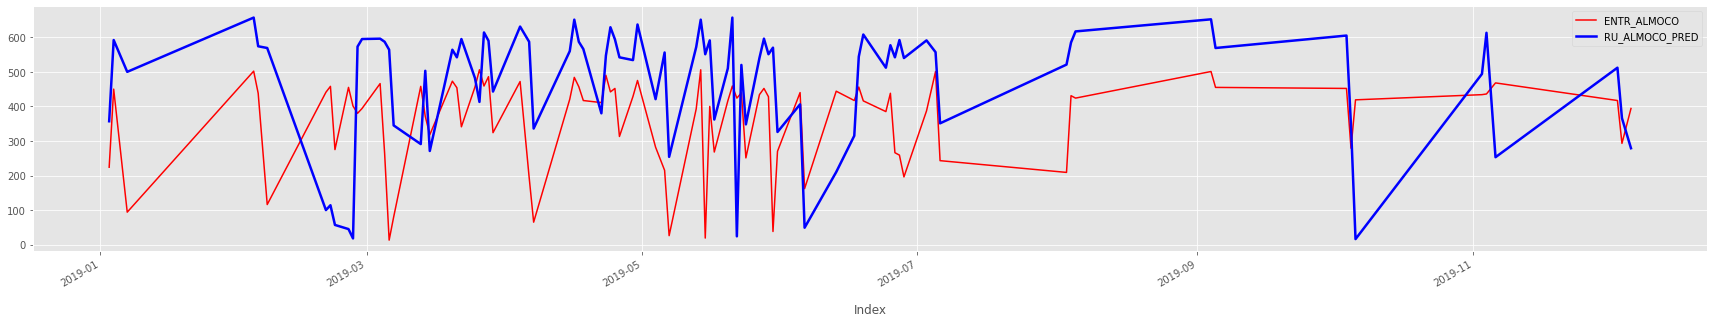

CORRELAÇÃO (r): 0.35016729421139536 Pi (p) :0.000824472804070928
RMSE = 138.39933164578505
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 19713
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 15196
TOTAL DE REFEIÇÕES SUB PROJETADAS = -2749
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 7266
ERRO ABSOLUTO MÉDIO = 113.80681818181819
ERRO ABSOLUTO PERCENTUAL MÉDIO = 183.87443608927114%


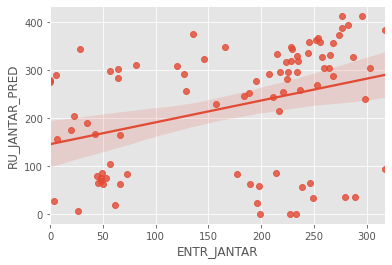

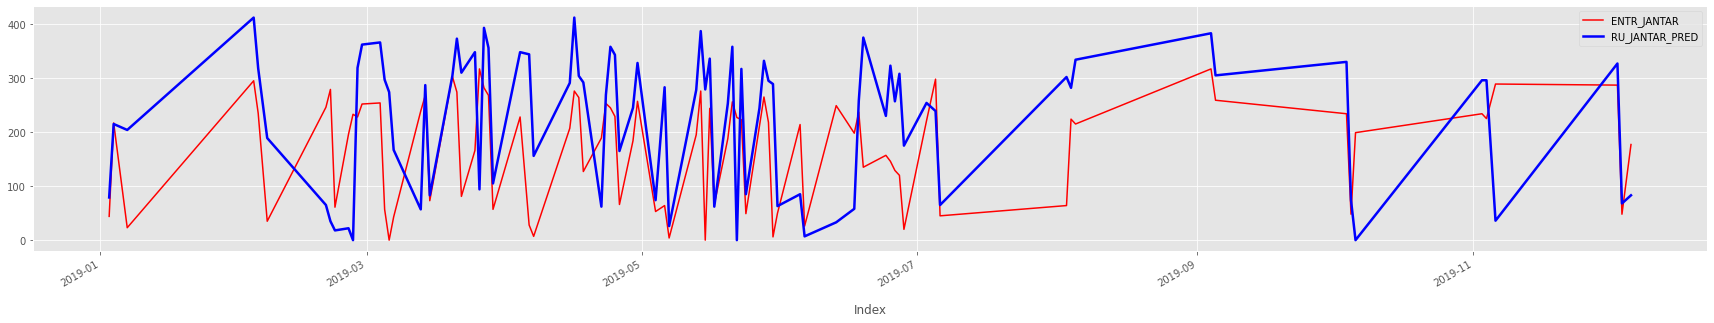

FEATURES CATEGORICAS, 0 = AUSENTE, 1 = PRESENTE
COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 5 DIAS ANTERIORES
CORRELAÇÃO (r): 0.5047927090016202 Pi (p) :4.074418137293535e-17
RMSE = 295.5650026337574
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 104343
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -9333
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 44132
ERRO ABSOLUTO MÉDIO = 220.02057613168725
ERRO ABSOLUTO PERCENTUAL MÉDIO = 121.86826150858927%


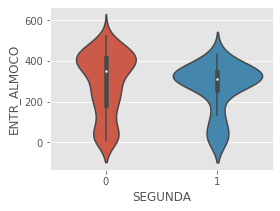

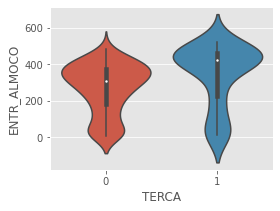

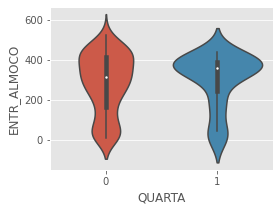

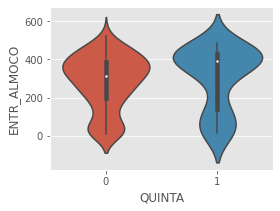

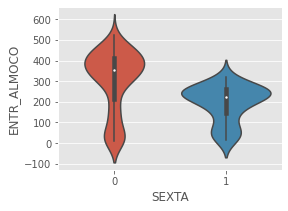

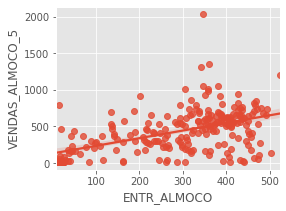

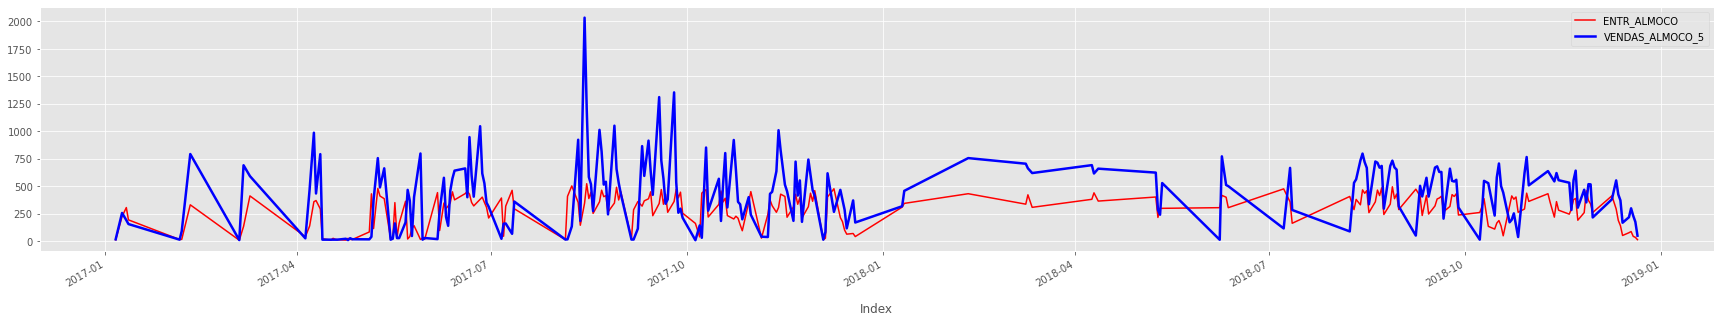

COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 1 DIA ANTERIOR
CORRELAÇÃO (r): 0.7255528038157009 Pi (p) :5.399561176138223e-41
RMSE = 260.5399426736619
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 104694
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4703
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 39853
ERRO ABSOLUTO MÉDIO = 183.35802469135803
ERRO ABSOLUTO PERCENTUAL MÉDIO = 90.1841604075917%


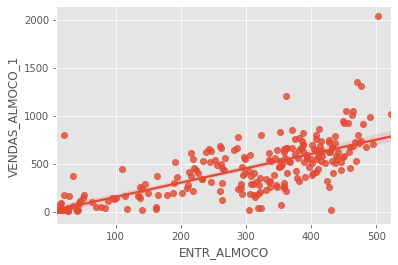

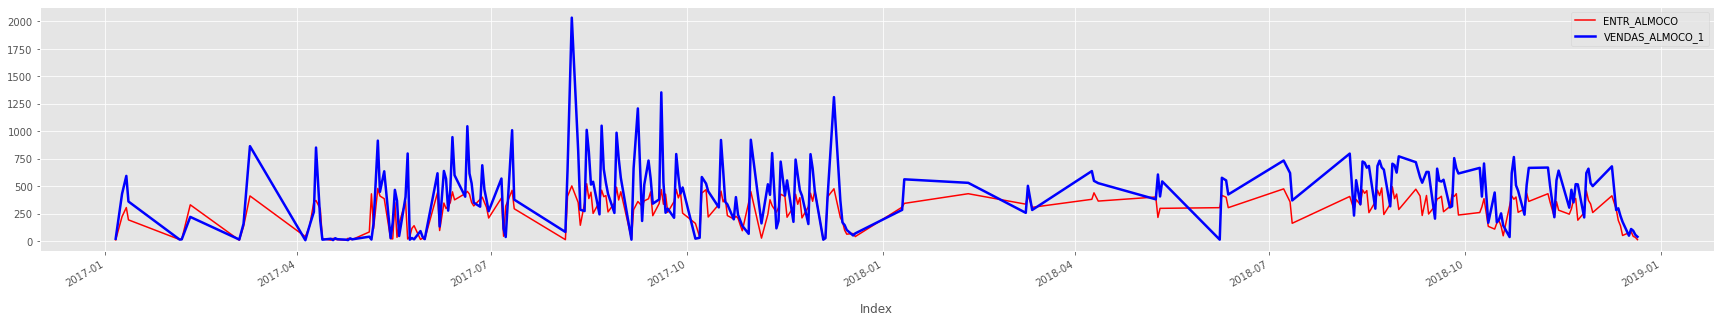

COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 2 DIAS ANTERIORES
CORRELAÇÃO (r): 0.479542402824923 Pi (p) :2.2317713861646184e-15
RMSE = 298.6730461179352
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 104648
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -10092
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 45196
ERRO ABSOLUTO MÉDIO = 227.52263374485597
ERRO ABSOLUTO PERCENTUAL MÉDIO = 106.44334684781136%


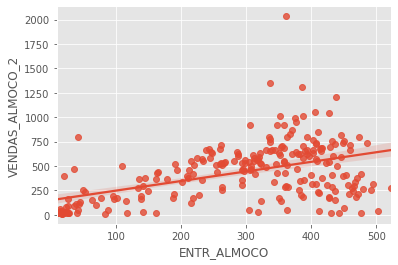

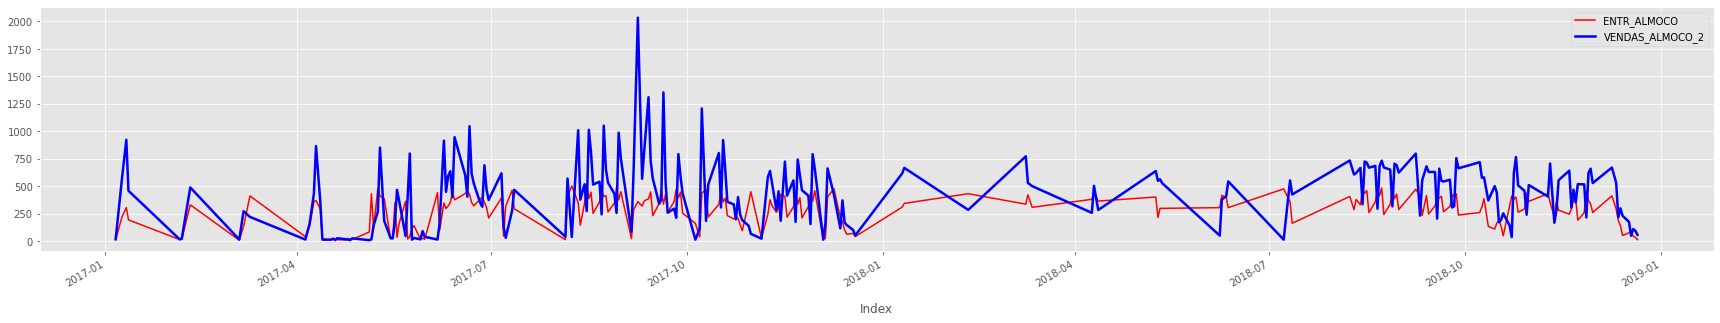

COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO SEMESTRE
CORRELAÇÃO (r): -0.3513881921486816 Pi (p) :1.8029942608003656e-08
RMSE = 280.21712433169444
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 13230.280000000002
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -57738.47000000002
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 1424.7499999999998
ERRO ABSOLUTO MÉDIO = 243.47004115226338
ERRO ABSOLUTO PERCENTUAL MÉDIO = 96.35790382621785%


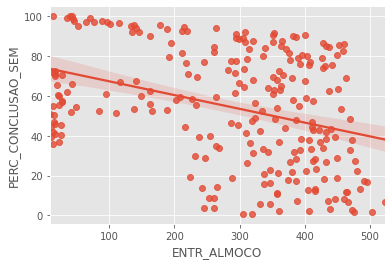

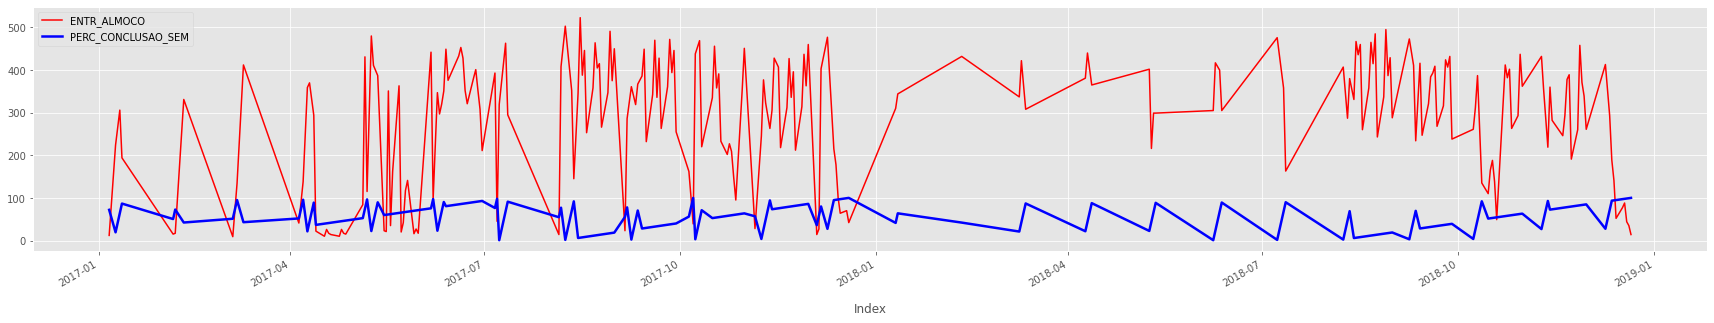

COMPORTAMENTO DE VENDAS EM RELAÇÃO AO AVANÇO DO MÊS
CORRELAÇÃO (r): 0.04867329355640767 Pi (p) :0.4500827452374414
RMSE = 275.8430566784226
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 12759.86
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -57851.969999999994
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 1067.8299999999997
ERRO ABSOLUTO MÉDIO = 242.46831275720166
ERRO ABSOLUTO PERCENTUAL MÉDIO = 95.88024182935077%


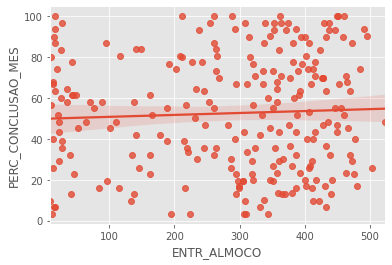

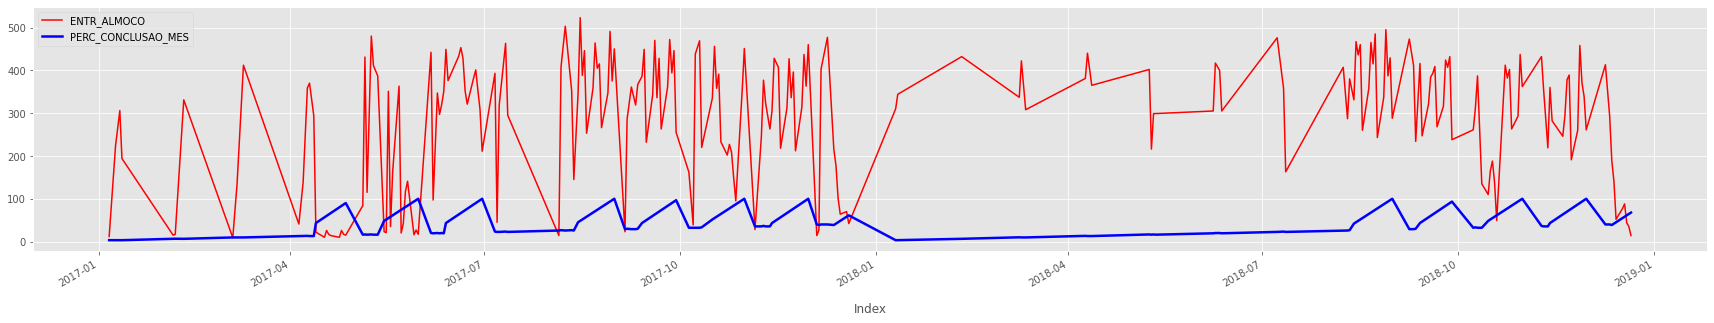

CORRELAÇÃO (r): -0.018062482389221743 Pi (p) :0.7793721946839797
RMSE = 319.43896935726696
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 413
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -69131
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 0
ERRO ABSOLUTO MÉDIO = 284.4897119341564
ERRO ABSOLUTO PERCENTUAL MÉDIO = 98.20971187645185%


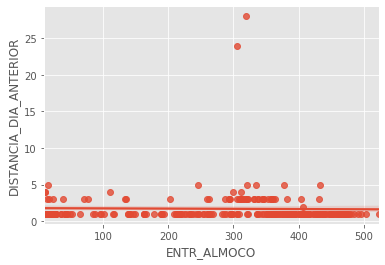

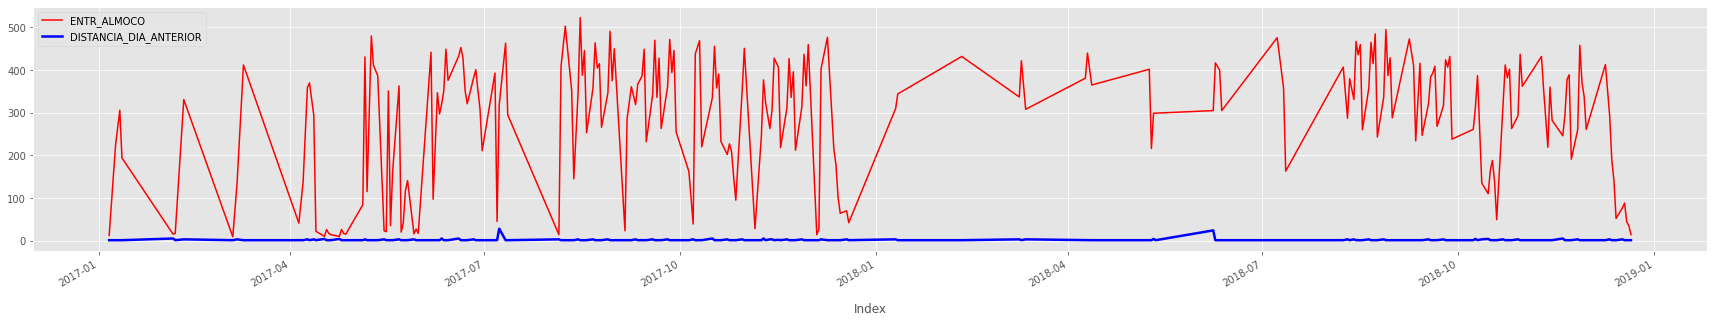

COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO POSTERIOR
CORRELAÇÃO (r): -0.22227339663145612 Pi (p) :0.00048157111944057004
RMSE = 319.6956886373874
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 518
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -69100
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 74
ERRO ABSOLUTO MÉDIO = 284.6666666666667
ERRO ABSOLUTO PERCENTUAL MÉDIO = 98.97056029430475%


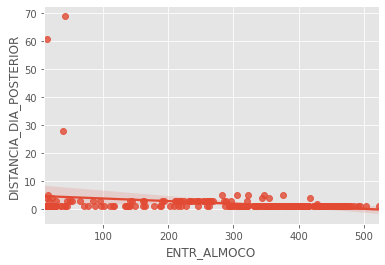

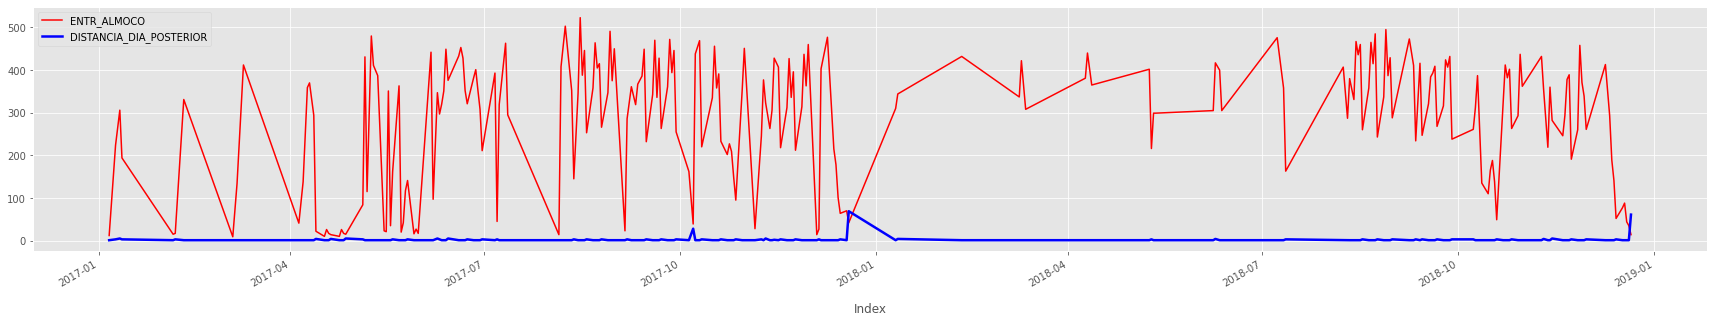

COMPORTAMENTO DE VENDAS EM RELAÇÃO À JANTA (CONSUMIDA) DE 1 DIA LETIVO ANTERIOR
CORRELAÇÃO (r): 0.765599143585576 Pi (p) :4.526981505307197e-48
RMSE = 165.29387721153316
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 36588
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -33251
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 295
ERRO ABSOLUTO MÉDIO = 138.0493827160494
ERRO ABSOLUTO PERCENTUAL MÉDIO = 56.623710305394745%


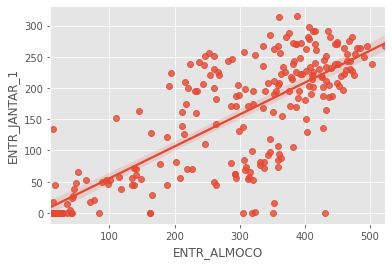

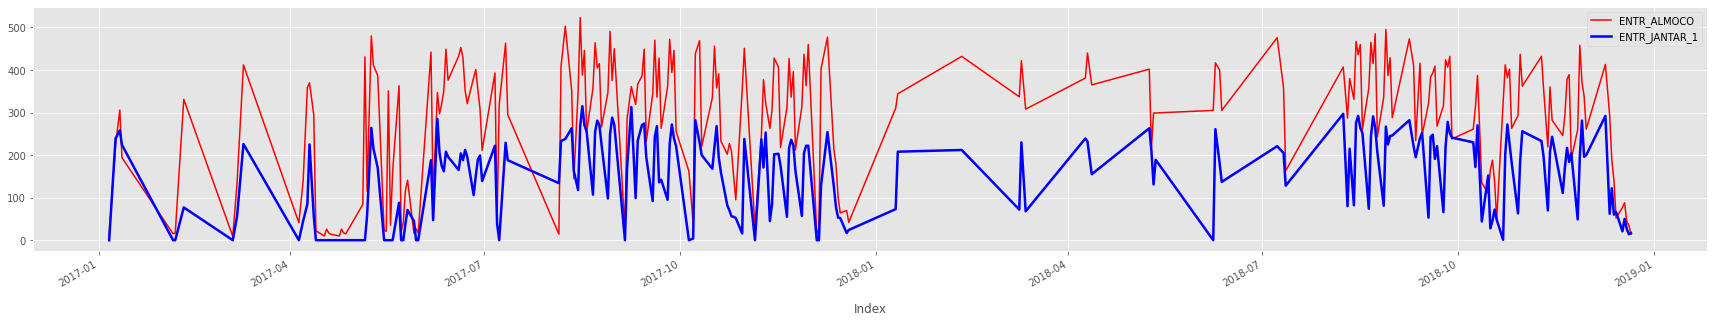

COMPORTAMENTO DE VENDAS EM RELAÇÃO À PRESSAO ATMOSFÉRICA
CORRELAÇÃO (r): 0.04736810123225091 Pi (p) :0.46233890663595634
RMSE = 679.3632868764366
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 230821.6
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = 0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 161277.59999999995
ERRO ABSOLUTO MÉDIO = 663.6938271604937
ERRO ABSOLUTO PERCENTUAL MÉDIO = 887.714259655517%


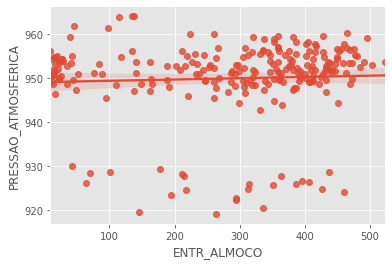

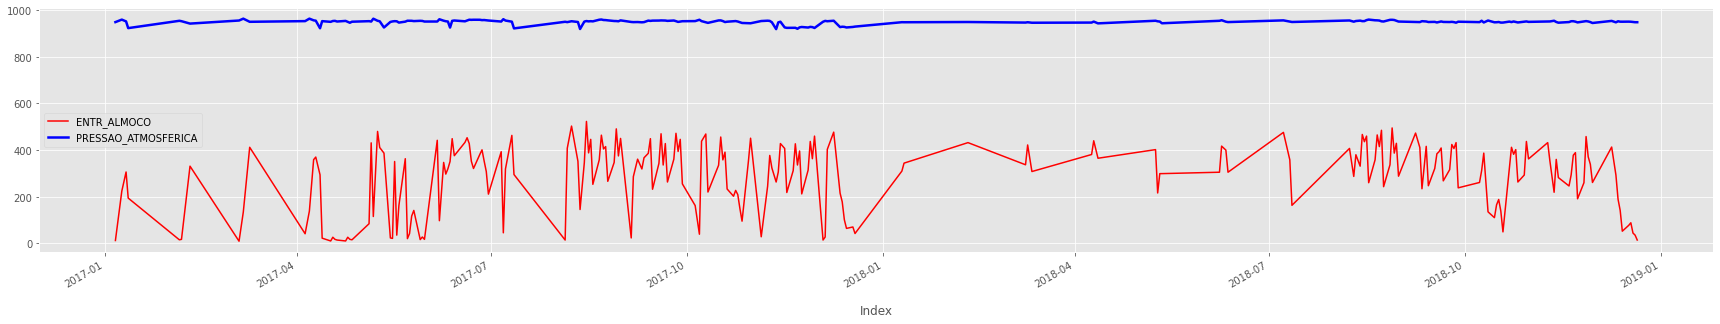

COMPORTAMENTO DE VENDAS EM RELAÇÃO À TEMPERATURA
CORRELAÇÃO (r): -0.05396535693356673 Pi (p) :0.4023062282373964
RMSE = 302.8673257317216
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 4986.899999999998
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -64646.100000000006
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 89.0
ERRO ABSOLUTO MÉDIO = 266.39958847736625
ERRO ABSOLUTO PERCENTUAL MÉDIO = 84.93896886137291%


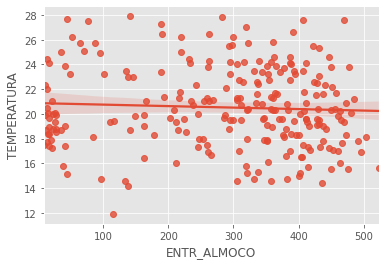

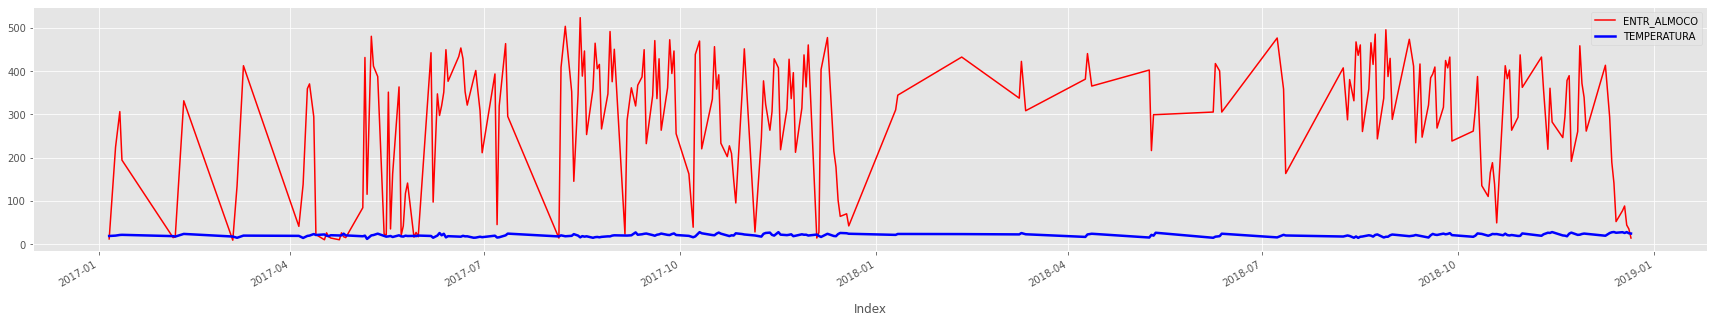

COMPORTAMENTO DE VENDAS EM RELAÇÃO AO VENTO
CORRELAÇÃO (r): 0.10553167833649073 Pi (p) :0.10076014518490854
RMSE = 318.64891841943626
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 601.8999999999999
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -68942.09999999999
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 0
ERRO ABSOLUTO MÉDIO = 283.71234567901234
ERRO ABSOLUTO PERCENTUAL MÉDIO = 97.70623744774804%


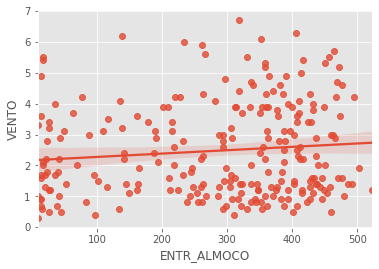

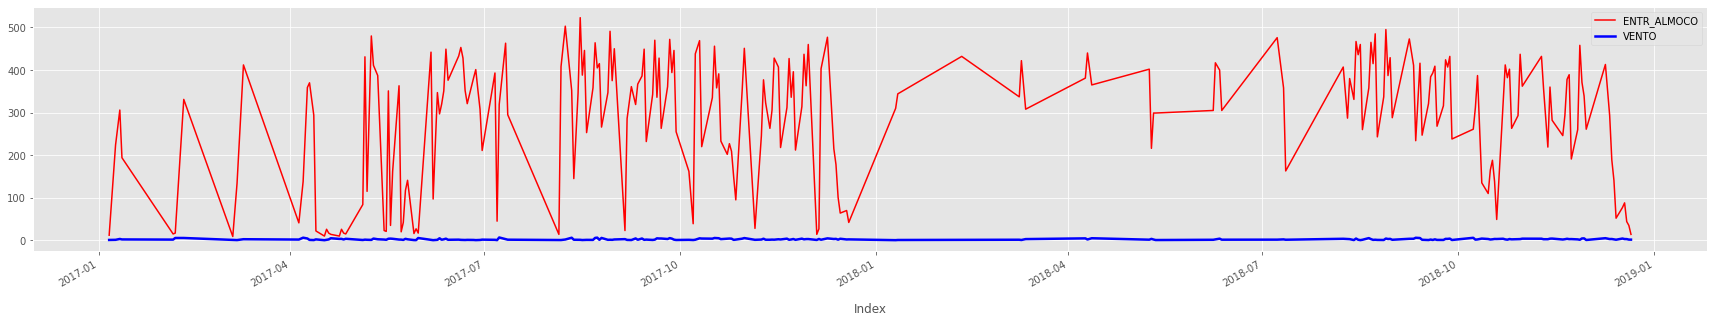

COMPORTAMENTO DE VENDAS EM RELAÇÃO À UMIDADE
CORRELAÇÃO (r): -0.11020852428559949 Pi (p) :0.08646474514211203
RMSE = 259.46220892469546
TOTAL DE REFEIÇÕES PROJETADAS = 243 : 17575
TOTAL DE REFEIÇÕES CONSUMIDAS = 243 : 69544
TOTAL DE REFEIÇÕES SUB PROJETADAS = -53770
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 1801
ERRO ABSOLUTO MÉDIO = 228.6872427983539
ERRO ABSOLUTO PERCENTUAL MÉDIO = 105.20079647268925%


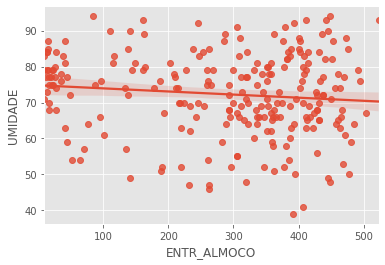

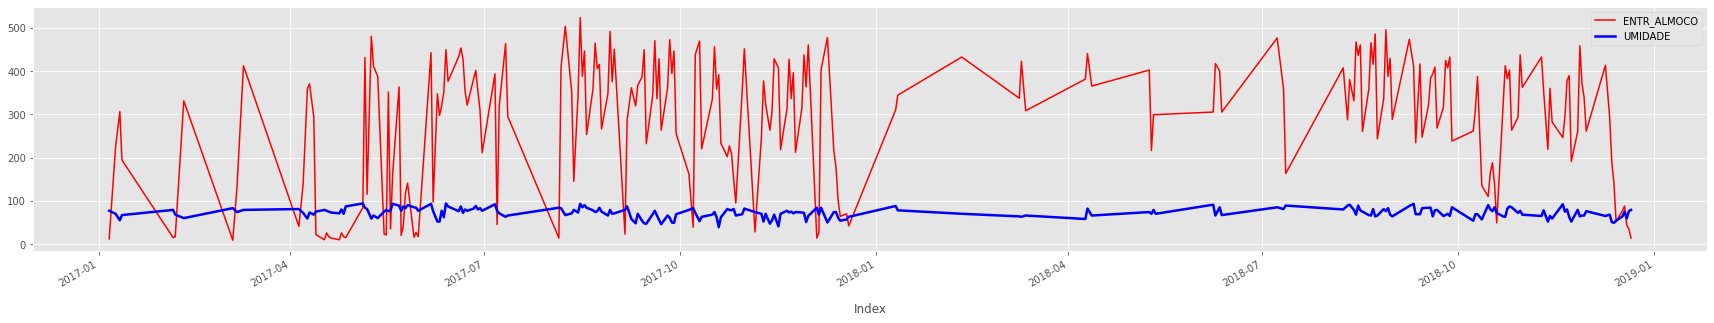

In [ ]:
#%% md

# TECNICA DO R.U, ANÁLISE DA 5A ÚLTIMA VENDA - CONJUNTO DE TESTE

#%% PREVISÃO DO R.U - CALCULO DO ALMOÇO

df_models_metrics2 = pd.DataFrame()

factor = 0.3
df_test['RU_ALMOCO_PRED'] = df_test.apply(lambda row: ru_pred_almoco(row,factor), axis=1)

#%% PREVISÃO DO R.U - CALCULO DO JANTAR

factor = 0.3
df_test['RU_JANTAR_PRED'] = df_test.apply(lambda row: ru_pred_jantar(row,factor), axis=1)

#%% PREVISÃO DO R.U - AVALIAÇÃO ALMOÇO

ru_almoco_metrics = []
ru_almoco_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'RU_ALMOCO_PRED',df_models_metrics2)

#%% PREVISÃO DO R.U - AVALIAÇÃO JANTAR

ru_jantar_metrics = []
ru_jantar_metrics = avaliacao_predicoes(df_test,'ENTR_JANTAR', 'RU_JANTAR_PRED',df_models_metrics2)

#%% md

# ANALISANDO AS FEATURES DO DATASET

#%% md

## ANÁLISES DAS FEATURES CATEGORICAS

#%%

print('FEATURES CATEGORICAS, 0 = AUSENTE, 1 = PRESENTE')
plt.figure(figsize=(4,3))
sns.violinplot(x='SEGUNDA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='TERCA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='QUARTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='QUINTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='SEXTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))


#%% md

## ANÁLISES DAS FEATURES QUATITATIVAS

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 5 DIAS ANTERIORES')
VENDAS_ALMOCO_5_metrics = []
VENDAS_ALMOCO_5_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_5',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 1 DIA ANTERIOR')
VENDAS_ALMOCO_1_metrics = []
VENDAS_ALMOCO_1_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_1',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 2 DIAS ANTERIORES')
VENDAS_ALMOCO_2_metrics = []
VENDAS_ALMOCO_2_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_2',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO SEMESTRE

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO SEMESTRE')
PERC_CONCLUSAO_SEM_metrics = []
PERC_CONCLUSAO_SEM_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PERC_CONCLUSAO_SEM',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO MÊS

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO AO AVANÇO DO MÊS')
PERC_CONCLUSAO_MES_metrics = []
PERC_CONCLUSAO_MES_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PERC_CONCLUSAO_MES',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO ANTERIOR

ENTR_ALMOCO_metrics = []
ENTR_ALMOCO_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'DISTANCIA_DIA_ANTERIOR',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO ANTERIOR

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO POSTERIOR')
DISTANCIA_DIA_POSTERIOR = []
DISTANCIA_DIA_POSTERIOR = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'DISTANCIA_DIA_POSTERIOR',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À JANTA (CONSUMIDA) DE 1 DIA LETIVO ANTERIOR

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À JANTA (CONSUMIDA) DE 1 DIA LETIVO ANTERIOR')
ENTR_JANTAR_1_metrics = []
ENTR_JANTAR_1_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'ENTR_JANTAR_1',df_models_metrics2)


#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À PRESSAO ATMOSFÉRICA

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À PRESSAO ATMOSFÉRICA')
PRESSAO_ATMOSFERICA_metrics = []
PRESSAO_ATMOSFERICA_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PRESSAO_ATMOSFERICA',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À TEMPERATURA

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À TEMPERATURA')
TEMPERATURA_metrics = []
TEMPERATURA_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'TEMPERATURA',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO AO VENTO

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO AO VENTO')
VENTO_metrics = []
VENTO_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENTO',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À UMIDADE

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À UMIDADE')
UMIDADE_metrics = []
UMIDADE_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'UMIDADE',df_models_metrics2)

#### **FORMATANDO FEATURES TEMPORAIS PARA SHAPE COMPATÍVEL COM REDES RECORRENTES**
shape = (num_samples,   num_lags_passados,   num_features)

In [ ]:
# pegando features temporais
# IMPORTANTE ESTAR EM ORDEM !! PRIMEIRO ELEMENTO = Y E OS DEMAIS = X0, X1, ...
feature_0 = ['ENTR_ALMOCO', 'ENTR_ALMOCO_1', 'ENTR_ALMOCO_2','ENTR_ALMOCO_3', 'ENTR_ALMOCO_4', 'ENTR_ALMOCO_5',]
feature_1 = ['VENDAS_ALMOCO','VENDAS_ALMOCO_1','VENDAS_ALMOCO_2','VENDAS_ALMOCO_3','VENDAS_ALMOCO_4','VENDAS_ALMOCO_5']
feature_2 = ['ENTR_JANTAR','ENTR_JANTAR_1', 'ENTR_JANTAR_2', 'ENTR_JANTAR_3', 'ENTR_JANTAR_4','ENTR_JANTAR_5']
features_temporais = [feature_0, feature_1, feature_2]
##################################################
feature_to_predict = 0 # ENTR_ALMOCO, feature 0 que será o valor da saída do modelo (trocar se quiser)
##################################################
num_temporais = len(features_temporais) # 3 séries temporais


train_x, train_y = [], []
val_x, val_y = [], []
test_x, test_y = [], []
# serapando em dfs com somente uma feature
for feature_cols in features_temporais:
    # train
    x, y = to_supervised_numpy(df_train[feature_cols], feature_cols[0]) # feature[0] = ENTR_ALMOCO = y!!! IMPORTANTE  
    train_x.append(x); train_y.append(y)
    # validacao
    x, y = to_supervised_numpy(df_val[feature_cols], feature_cols[0]) # feature[0] = VENDAS_ALMOCO = y!!! IMPORTANTE  
    val_x.append(x); val_y.append(y)
    # test
    x, y = to_supervised_numpy(df_test[feature_cols], feature_cols[0]) # feature[0] = ENTR_JANTAR = y !!! IMPORTANTE  
    test_x.append(x); test_y.append(y)

    
# transforma em numpy array
train_x = np.array(train_x);  train_y = np.array(train_y); 
val_x = np.array(val_x);  val_y = np.array(val_y); 
test_x = np.array(test_x);  test_y = np.array(test_y); 
#
print('shape treino:', val_x.shape, val_y.shape)
print('shape validacao:', train_x.shape, train_y.shape)
print('shape teste:', test_x.shape, test_y.shape)

shape treino: (3, 89, 5) (3, 89)
shape validacao: (3, 243, 5) (3, 243)
shape teste: (3, 88, 5) (3, 88)


#### **TRATAMENTO DE OUTLIERS NAS FEATURES TEMPORAIS**
verifica se é distante da média

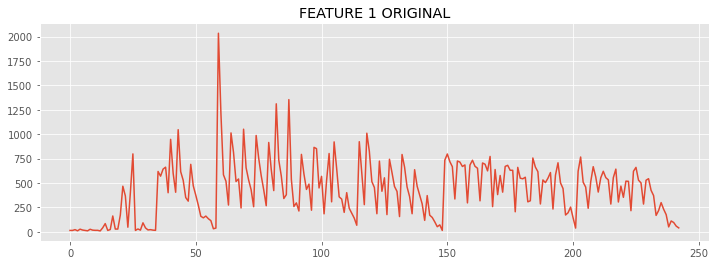

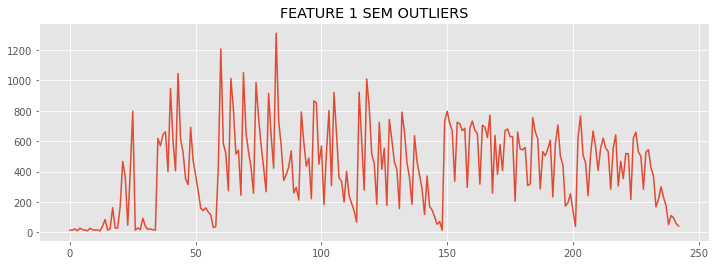

10 outliers  aredondados para a media


In [ ]:
TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS = True
tolerancia_sigma = 3
num_outliers = 0
if TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS:
    plot_serie(train_x[1, :, 0], title='FEATURE 1 ORIGINAL')
    num_outliers = 0
    for feature_i in range(num_temporais):
        desvio_padrao = np.std(train_x[feature_i, :, 0])
        media = np.mean(train_x[feature_i, :, 0])
        for lag_i in range(train_x.shape[2]):
            for element_i in range(train_x.shape[1]):
                valor = train_x[feature_i, element_i, lag_i]
                if np.abs(valor - media) >= tolerancia_sigma*desvio_padrao:
                    train_x[feature_i, element_i, lag_i] = media
                    num_outliers += 1
    
    plot_serie(train_x[1, :, 0], title='FEATURE 1 SEM OUTLIERS')
    print(num_outliers, 'outliers  aredondados para a media')

#### **ESCALONANDO FEATURES TEMPORAIS (MINMAX SCALER)**

Criados 3 scalers para as features temporais
(3, 5, 243, 1) (3, 243, 1)
(3, 5, 89, 1) (3, 89, 1)
(3, 5, 88, 1) (3, 88, 1)


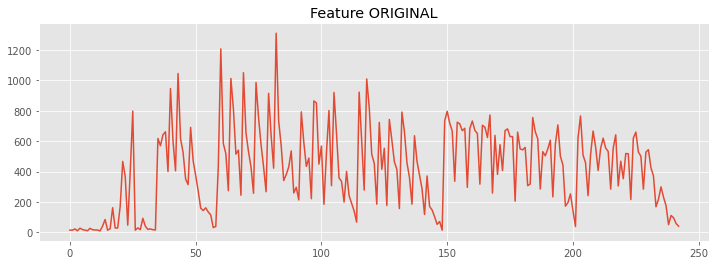

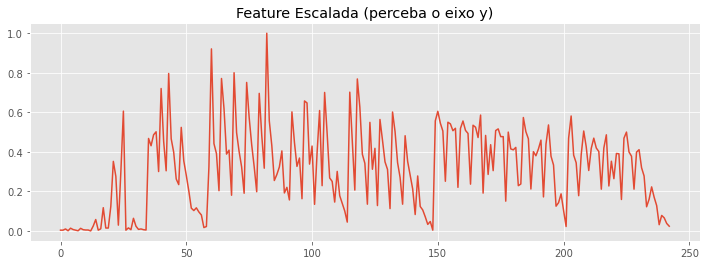

In [ ]:
#
# o correto seria escalonar antes de dividir em lags mas como ja foi dividido sera preciso
# fazer dessa forma não muito otimizada
# escalando features
scalers = [MinMaxScaler([0,1]) for i in range(num_temporais)] # Um scaler para cada feature TEMPORAL
print('Criados', len(scalers),'scalers para as features temporais')

# nao é a maneira mais eficiente, mas é a mais facil de implementar nessas condicoes

def treina_scalers(train_x):
    for i in range(len(train_x)): # pra cada feature
        feature_x = train_x[i]
        scalers[i].fit(feature_x[:, 0].reshape(-1,1)) # poderia usar qualquer coluna(lag), usando a primeira aqui
#     
def scala_features(data_x, data_y):
    scaled_data_x, scaled_data_y = [], []
    for feature_i in range(len(data_x)): # pra cada feature
        x = data_x[feature_i]; y = data_y[feature_i].reshape(-1, 1)
        scaled_x = []
        # pra cada lag, aplicar transform depois de ter 'treinado' o scaler(calculado parametros media etc)
        for lag in range(x.shape[1]): # x.shape[1] = numero de lags (nesse caso 5)
            lag_scaled = scalers[feature_i].transform(x[:, lag].reshape(-1,1)) # lag atual, ENTR_JANTAR_'lag' por exemplo
            scaled_x.append(lag_scaled) # adiciona cada lag no vetor de retorno, lag_1, lag_2 .. lag_5
        # scaled_x = vetor de lags para a feature do for mais externo, feature de indice feature_i
        scaled_data_x.append(np.array(scaled_x))
        scaled_data_y.append(scalers[feature_i].transform(y))
    return np.array(scaled_data_x), np.array(scaled_data_y)


# treina
treina_scalers(train_x) # treina os scalers para depois usar
# fit transform
scaled_train_x, scaled_train_y = scala_features(train_x, train_y)
scaled_val_x, scaled_val_y = scala_features(val_x, val_y)
scaled_test_x, scaled_test_y = scala_features(test_x, test_y)


# (num_features, num_lags, num_samples, 1) e (num_features, num_samples, 1)
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)

#
feature_para_ver = 1
plot_serie(train_x[feature_para_ver, :, 0], title='Feature ORIGINAL')
plot_serie(scaled_train_x[feature_para_ver, 0, :, 0], title='Feature Escalada (perceba o eixo y)')


#### **TRANSPONDO MATRIZES (SÓ UMA CONVENÇÃO, NÃO ALTERA NADA)**
Transpõe matrizes para ordem correta dos eixos
* Shape de Antes: **data_X:(num_features, num_lags, num_instancias, 1) data_Y:(num_features, num_instancias, 1)**
* Shape de Depois: **data_X:(num_instancias, num_lags, num_features) data_Y:(num_instancias, num_features)**

In [ ]:
def transpose_to_rnn(data_x, data_y): # faz a transposição (necessario devido ao problema citado acima)
    data_x = data_x.transpose(2, 1, 0, 3)
    data_y = data_y.transpose(1, 0, 2)
    data_x = np.squeeze(data_x) # remove ultima dimensão desnecessaria()
    data_y = np.squeeze(data_y) # remove ultima dimensão desnecessaria()

    return data_x, data_y
# sobreescreve matrizes , portanto executar uma única vez
scaled_train_x, scaled_train_y = transpose_to_rnn(scaled_train_x, scaled_train_y)
scaled_val_x, scaled_val_y = transpose_to_rnn(scaled_val_x, scaled_val_y)
scaled_test_x, scaled_test_y = transpose_to_rnn(scaled_test_x, scaled_test_y)
#
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)
#

(243, 5, 3) (243, 3)
(89, 5, 3) (89, 3)
(88, 5, 3) (88, 3)


#### **REMOVENDO Y QUE NÃO QUEREMOS PREVER DAS FEATURES TEMPORAIS(JANTA POR EXEMPLO)**


In [ ]:
# os vetores train_y, val_y e test_y possuem o y para todas as features
# porém queremos prever somente uma delas (saida da rede pode ser as tres caso quisermos)
# portanto vamos retirar as outras dos vetores y

# dados originais
train_y = train_y[feature_to_predict,:]
val_y = val_y[feature_to_predict,:]
test_y = test_y[feature_to_predict,:]
# dados escalados
scaled_train_y = scaled_train_y[:, feature_to_predict]
scaled_val_y = scaled_val_y[:, feature_to_predict]
scaled_test_y = scaled_test_y[:, feature_to_predict]
print(scaled_train_y.shape)
print(scaled_val_y.shape)
print(scaled_test_y.shape)

(243,)
(89,)
(88,)


#### **SEPARA FEATURES NÃO TEMPORAIS (ONE HOT E NUMERICAS)**


In [ ]:
# features one hot
features_categoricas = ['SEMESTRE_1', 'SEMESTRE_2']
# divide df completo
train_x_cat = df_train[features_categoricas].values
val_x_cat = df_val[features_categoricas].values
test_x_cat = df_test[features_categoricas].values
print('features categoricas one_hot: ',train_x_cat.shape, val_x_cat.shape, test_x_cat.shape)




#features numericas pontuais
features_numericas_pontuais = ['DISTANCIA_DIA_ANTERIOR', 'DISTANCIA_DIA_POSTERIOR',
       'PERC_CONCLUSAO_SEM', 'PERC_CONCLUSAO_MES', 'PRESSAO_ATMOSFERICA',
       'TEMPERATURA', 'UMIDADE', 'VENTO']
# divide df completo
train_x_numpont = df_train[features_numericas_pontuais].values
val_x_numpont = df_val[features_numericas_pontuais].values
test_x_numpont = df_test[features_numericas_pontuais].values
print('features numericas pontuais:', train_x_numpont.shape, val_x_numpont.shape, test_x_numpont.shape)

features categoricas one_hot:  (243, 2) (89, 2) (88, 2)
features numericas pontuais: (243, 8) (89, 8) (88, 8)


#### **ESCALA FEATURES NÃO TEMPORAIS E COMPACTA EM UM UNICO VETOR**


In [ ]:
# scaler das features numericas não temporais (temperatura, umidade etc) 
# nesse caso pode usar um unico scaler (ele cria diferentes estatisticas para cada feature)
scaler_numpont = MinMaxScaler([0,1]).fit(train_x_numpont)
train_x_numpont = scaler_numpont.transform(train_x_numpont)
val_x_numpont = scaler_numpont.transform(val_x_numpont)
test_x_numpont = scaler_numpont.transform(test_x_numpont)

# concatena tudo pra alimentar parte densa do modelo
train_x_dense = np.hstack([train_x_numpont, train_x_cat])
val_x_dense = np.hstack([val_x_numpont, val_x_cat])
test_x_dense = np.hstack([test_x_numpont, test_x_cat])

print('treino', train_x_dense.shape)
print('validacao', val_x_dense.shape)
print('teste', test_x_dense.shape)

treino (243, 10)
validacao (89, 10)
teste (88, 10)


In [ ]:
# RESULTADO 
print(scaled_train_x.shape, ' e ', train_x_dense.shape)

(243, 5, 3)  e  (243, 10)


# **Definição e Treino de Modelos**

## EXPLORANDO O PROBLEMA (RODAR PRIMEIROS TREINOS)
 CRIAR UMA MLP PADRÃO (1 CAMADA 1 SAÍDA), CHEGANDO NELA TODAS AS FEATURES ESCALADAS
 DEIXA-LA PREPARADA PARA SER USADA PARA PREVISÕES ASSIM COMO AS OUTRAS
 ESTA MLP SERÁ USADA PARA EXPLORAR O DOMÍNIO DO PROBLEMA E REALIZAR PRIMEIROS TREINOS. 
 O MAIS IMPORTANTE AQUI É TER O DATASET CHEGANDO INTEIRO E ESCALADO.

In [ ]:
num_lags = scaled_train_x.shape[1] # = 5 #JANELA TEMPORAL
num_features = scaled_train_x.shape[2] # = 3 #NUMERO DE FEATURES (VENDA_ALMOCO,ENTR_ALMOCO,ENTR_JANTAR)
num_output = 1 # ENTR_ALMOCO
learning_rate = 0.001 # bom valor
feature_to_predict = 0 #ENTR_ALMOCO

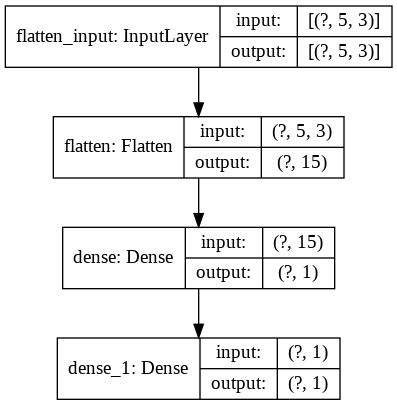

In [ ]:
#%%
###################### modelo MLP com uma única camada
current_model = 'mlp_1'
MLP1 = keras.Sequential()
MLP1.add(layers.Flatten(input_shape=(num_lags, num_features),))
#model_mlp_unique_1.add(layers.Dense(64, activation='relu'))
#model_mlp_unique_1.add(layers.Dense(32, activation='relu'))
MLP1.add(layers.Dense(1, activation='relu'))
MLP1.add(layers.Dense(num_output, activation='linear'))
MLP1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(MLP1, show_shapes=True)
#MLP1.save_weights(workpath + prefix + current_model + "_wheigts_initial.h5")
######################

(243, 5, 3) (243,)


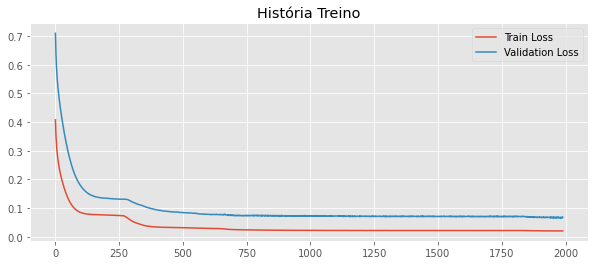

In [ ]:
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = MLP1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

In [ ]:
pred_y1 = MLP1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y1 = scalers[feature_to_predict].inverse_transform(pred_y1)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


CORRELAÇÃO (r): 0.5632222885256227 Pi (p) :9.1524967488764e-09
RMSE = 134.6299068973184
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 30203.194660186768
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -7427.4657554626465
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2075.660415649414
ERRO ABSOLUTO MÉDIO = 106.7766985518209
ERRO ABSOLUTO PERCENTUAL MÉDIO = 42.60673344160612%


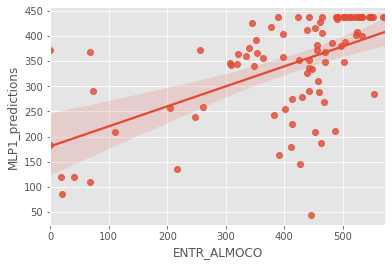

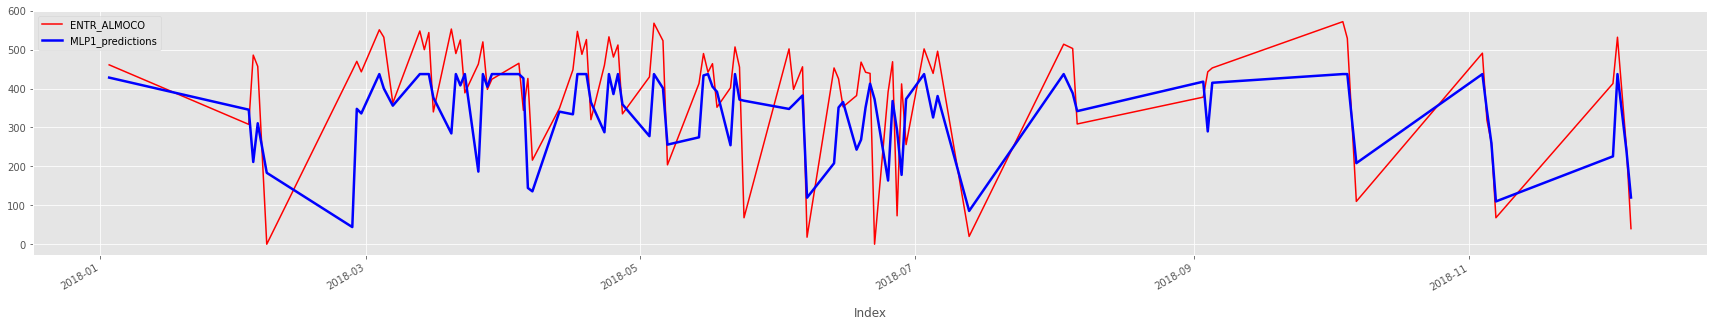

(0.5632222885256227,
 9.1524967488764e-09,
 134.6299068973184,
 42.60673344160612,
 -7427.4657554626465,
 2075.660415649414)

In [ ]:
import scipy
import seaborn as sns
df_val['MLP1_predictions'] = pred_y1
avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'MLP1_predictions',df_models_metrics)

In [ ]:
df_models_metrics

parameters  MLP1_predictions
0       TOTAL_PROJETADAS      30203.194660
1       TOTAL_CONSUMIDAS      35555.000000
2    TOTAL_SUBPROJETADAS      -7427.465755
3  TOTAL_SUPERPROJETADAS       2075.660416
4         ERRO_ABS_MEDIO        106.776699
5     ERRO_ABS_PER_MEDIO         42.606733

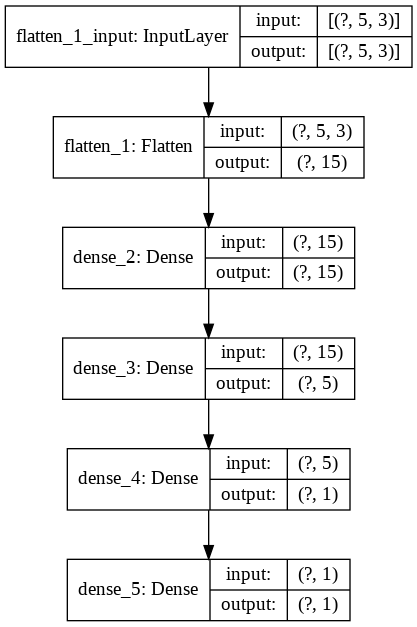

In [ ]:
#%%
###################### modelo MLP 2 com mais camadas
current_model = 'mlp_1'
MLP2 = keras.Sequential()
MLP2.add(layers.Flatten(input_shape=(num_lags, num_features),))
MLP2.add(layers.Dense(15, activation='relu'))
MLP2.add(layers.Dense(5, activation='relu'))
MLP2.add(layers.Dense(1, activation='relu'))
MLP2.add(layers.Dense(num_output, activation='linear'))
MLP2.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(MLP2, show_shapes=True)
#MLP1.save_weights(workpath + prefix + current_model + "_wheigts_initial.h5")
######################

(243, 5, 3) (243,)


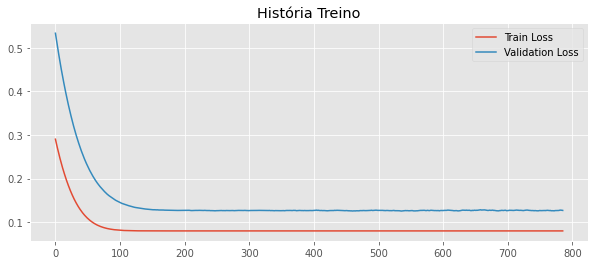

In [ ]:
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = MLP2.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CORRELAÇÃO (r): nan Pi (p) :nan
RMSE = 182.00783398452992
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 25607.397888183594
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -12394.732116699219
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2447.1300048828125
ERRO ABSOLUTO MÉDIO = 166.7624957481127
ERRO ABSOLUTO PERCENTUAL MÉDIO = 81.9152217982743%


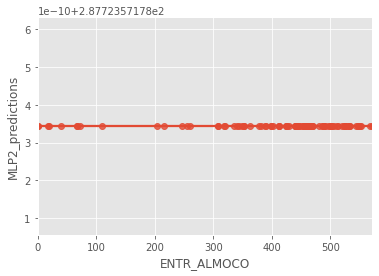

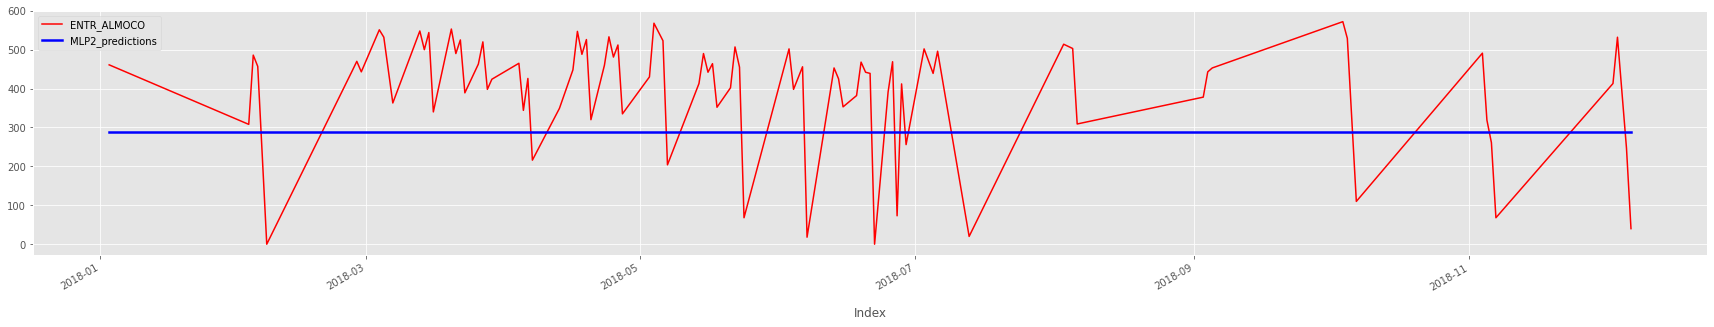

(nan,
 nan,
 182.00783398452992,
 81.9152217982743,
 -12394.732116699219,
 2447.1300048828125)

In [ ]:
#MLP2
pred_y2 = MLP2.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y2 = scalers[feature_to_predict].inverse_transform(pred_y2)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))

df_val['MLP2_predictions'] = pred_y2
avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'MLP2_predictions',df_models_metrics)

In [ ]:
df_models_metrics

parameters  MLP1_predictions  MLP2_predictions
0       TOTAL_PROJETADAS      30203.194660      25607.397888
1       TOTAL_CONSUMIDAS      35555.000000      35555.000000
2    TOTAL_SUBPROJETADAS      -7427.465755     -12394.732117
3  TOTAL_SUPERPROJETADAS       2075.660416       2447.130005
4         ERRO_ABS_MEDIO        106.776699        166.762496
5     ERRO_ABS_PER_MEDIO         42.606733         81.915222

## **Modelos que usam somente dados endógenos**

In [ ]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_output = 1 # saída é um unico numero escalar
learning_rate = 0.001 # bom valor

### model_rnn_unique_1

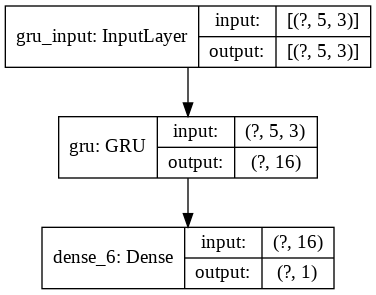

In [ ]:
#model_rnn_unique_1
###################### modelo RNN com uma única camada 
model_rnn_unique_1 = keras.Sequential()
num_units = 16 # ajustavel
model_rnn_unique_1.add(layers.GRU(num_units, input_shape=(num_lags, num_features),))
model_rnn_unique_1.add(layers.Dense(num_output, activation='linear'))
model_rnn_unique_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_rnn_unique_1, show_shapes=True)
######################

### model_rnn_unique_2

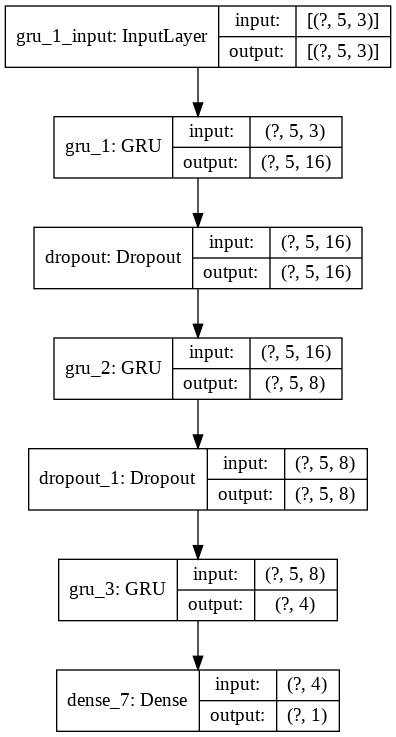

In [ ]:
#model_rnn_unique_2
###################### modelo RNN com mais de uma camada
model_rnn_unique_2 = keras.Sequential()
num_units = 16 # ajustavel
num_units_2 = 8 # ajustavel
num_units_3 = 4 # ajustavel
model_rnn_unique_2.add(layers.GRU(num_units, input_shape=(num_lags, num_features), return_sequences=True)) # return_sequences=True
model_rnn_unique_2.add(layers.Dropout(0.2)) # não necessário porém é bom
model_rnn_unique_2.add(layers.GRU(num_units_2, return_sequences=True))
model_rnn_unique_2.add(layers.Dropout(0.2)) # não necessário porém é bom
model_rnn_unique_2.add(layers.GRU(num_units_3, return_sequences=False)) # return_sequences=False
model_rnn_unique_2.add(layers.Dense(num_output, activation='linear'))


model_rnn_unique_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_rnn_unique_2, show_shapes=True)
######################

### model_mlp_unique_1

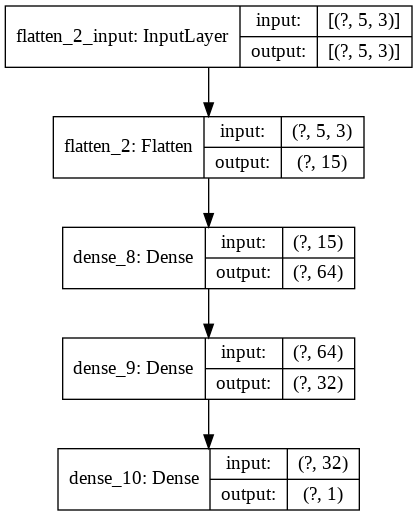

In [ ]:
#model_mlp_unique_1
###################### modelo MLP com uma única camada
model_mlp_unique_1 = keras.Sequential()
model_mlp_unique_1.add(layers.Flatten(input_shape=(num_lags, num_features),))
model_mlp_unique_1.add(layers.Dense(64, activation='relu'))
model_mlp_unique_1.add(layers.Dense(32, activation='relu'))
model_mlp_unique_1.add(layers.Dense(num_output, activation='linear'))
model_mlp_unique_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_mlp_unique_1, show_shapes=True)
######################

###TREINO DOS MODELOS

###model_rnn_unique_1

(243, 5, 3) (243,)


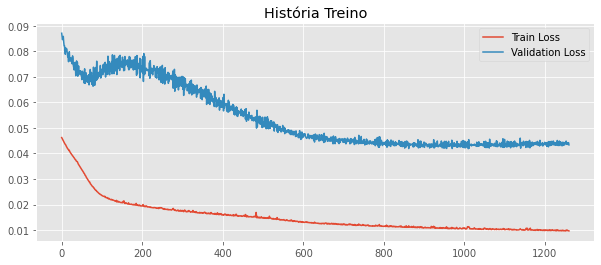

In [ ]:
#model_rnn_unique_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_rnn_unique_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

###model_rnn_unique_2

(243, 5, 3) (243,)


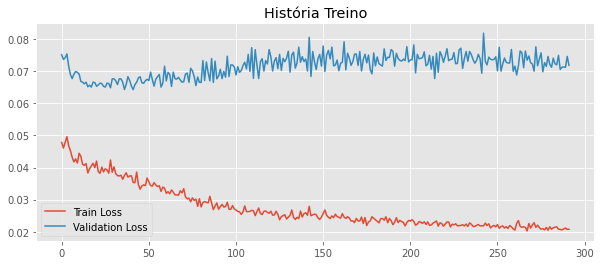

In [ ]:
#################################################################################
#################################################################################
#model_rnn_unique_2
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_rnn_unique_2.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

###model_mlp_unique_1

(243, 5, 3) (243,)


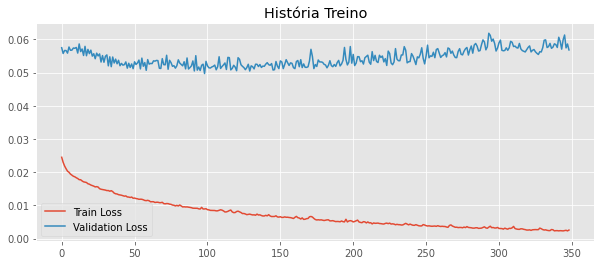

In [ ]:
#################################################################################
#################################################################################
#model_mlp_unique_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_mlp_unique_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

### **AVALIAÇÂO DO MODELO**

###model_rnn_unique_1

RMSE:  105.14869070560918


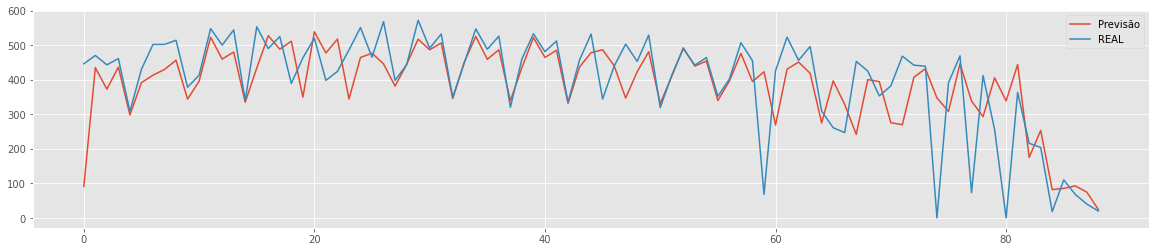

In [ ]:
#model_rnn_unique_1
pred_y_rnn_unique_1 = model_rnn_unique_1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y_rnn_unique_1 = scalers[feature_to_predict].inverse_transform(pred_y_rnn_unique_1)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y_rnn_unique_1)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y_rnn_unique_1, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.6921205269315444 Pi (p) :5.846776979938259e-14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE = 105.14869070560918
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 34557.803411483765
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3511.952590942383
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2514.7560024261475
ERRO ABSOLUTO MÉDIO = 67.71582689178123
ERRO ABSOLUTO PERCENTUAL MÉDIO = 28.133306553738013%


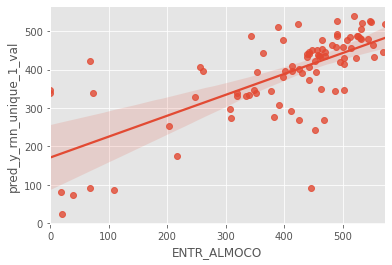

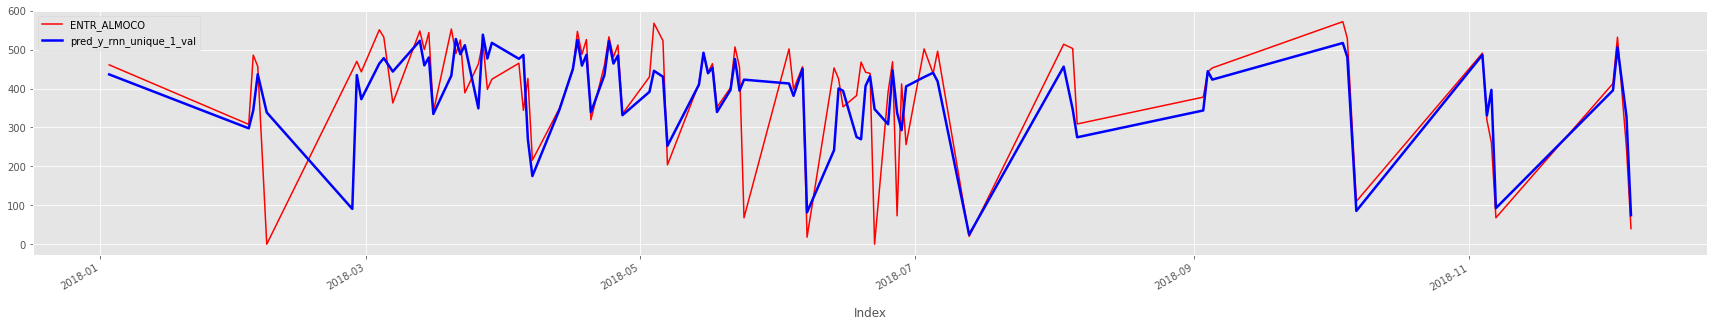

(0.6921205269315444,
 5.846776979938259e-14,
 105.14869070560918,
 28.133306553738013,
 -3511.952590942383,
 2514.7560024261475)

In [ ]:
df_val['pred_y_rnn_unique_1_val'] = pred_y_rnn_unique_1
avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'pred_y_rnn_unique_1_val',df_models_metrics)

In [ ]:
df_models_metrics

parameters  ...  pred_y_rnn_unique_1_val
0       TOTAL_PROJETADAS  ...             34557.803411
1       TOTAL_CONSUMIDAS  ...             35555.000000
2    TOTAL_SUBPROJETADAS  ...             -3511.952591
3  TOTAL_SUPERPROJETADAS  ...              2514.756002
4         ERRO_ABS_MEDIO  ...                67.715827
5     ERRO_ABS_PER_MEDIO  ...                28.133307

[6 rows x 4 columns]

###model_rnn_unique_2

RMSE:  130.275114481115


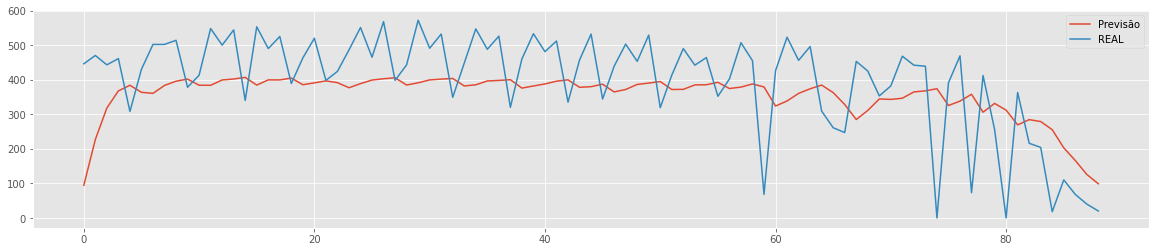

In [ ]:
#model_rnn_unique_2
pred_rnn_unique_2_val = model_rnn_unique_2.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_rnn_unique_2_val = scalers[feature_to_predict].inverse_transform(pred_rnn_unique_2_val)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_rnn_unique_2_val)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_rnn_unique_2_val, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.5273375102821387 Pi (p) :1.0993077308514959e-07


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE = 130.275114481115
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 31612.279235839844
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6841.1733322143555
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2898.452568054199
ERRO ABSOLUTO MÉDIO = 109.43399887942196
ERRO ABSOLUTO PERCENTUAL MÉDIO = 53.64571553242066%


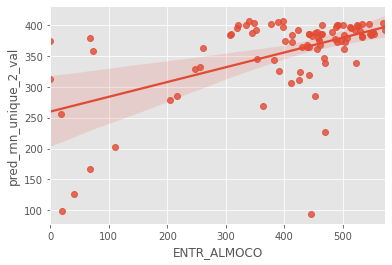

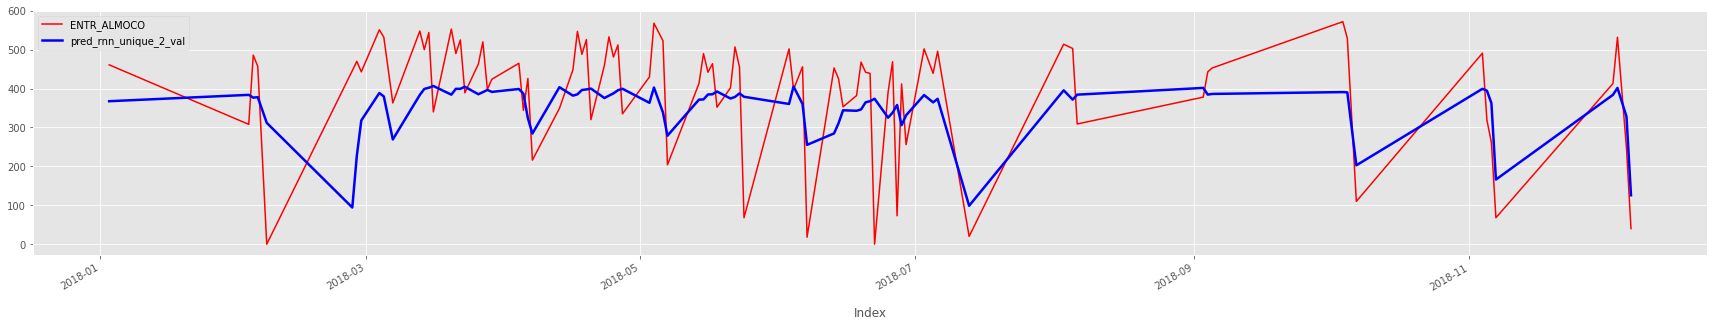

(0.5273375102821387,
 1.0993077308514959e-07,
 130.275114481115,
 53.64571553242066,
 -6841.1733322143555,
 2898.452568054199)

In [ ]:
df_val['pred_rnn_unique_2_val'] = pred_rnn_unique_2_val

avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'pred_rnn_unique_2_val',df_models_metrics)

###model_mlp_unique_1

RMSE:  114.58736070370354


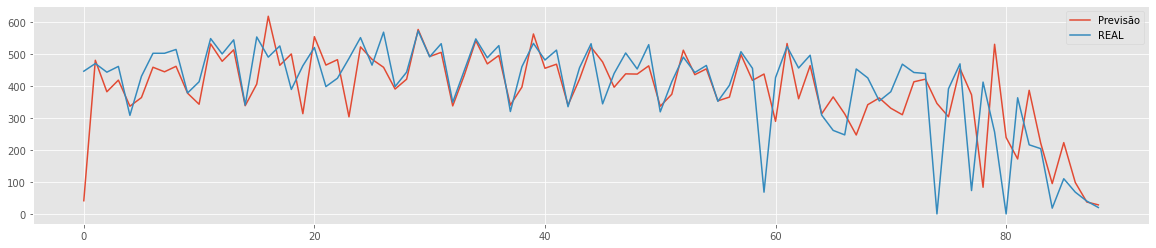

In [ ]:
#model_mlp_unique_1
pred_mlp_unique_1_val = model_mlp_unique_1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_mlp_unique_1_val = scalers[feature_to_predict].inverse_transform(pred_mlp_unique_1_val)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_mlp_unique_1_val)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_mlp_unique_1_val, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.6424421305585255 Pi (p) :1.1502472285142156e-11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE = 114.58736070370354
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 34740.04035949707
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3637.13431930542
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2822.1746788024902
ERRO ABSOLUTO MÉDIO = 72.57650559671809
ERRO ABSOLUTO PERCENTUAL MÉDIO = 31.618968913030653%


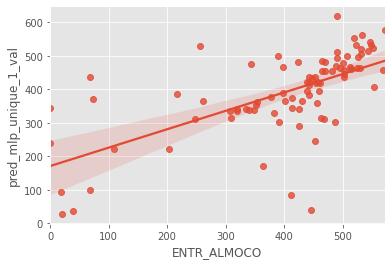

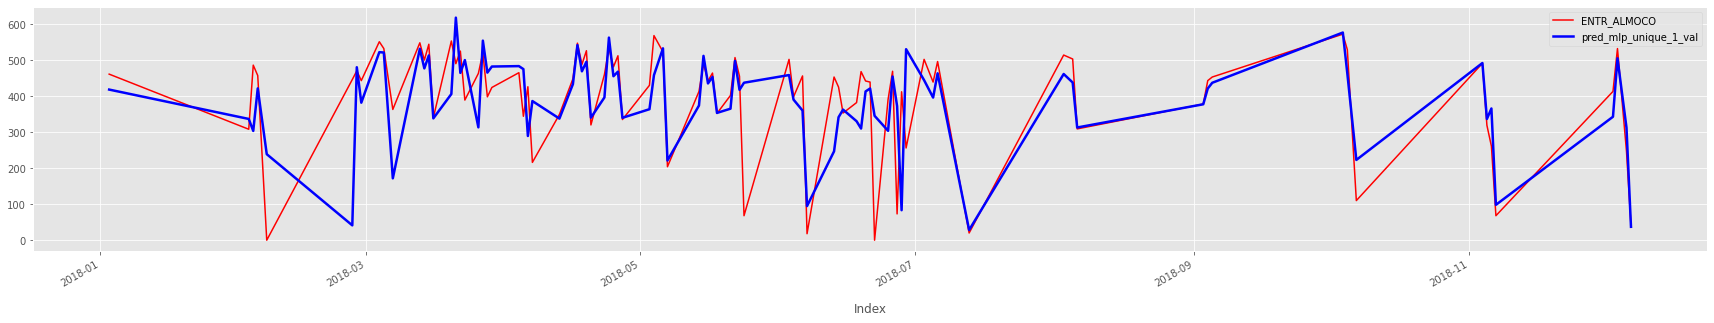

(0.6424421305585255,
 1.1502472285142156e-11,
 114.58736070370354,
 31.618968913030653,
 -3637.13431930542,
 2822.1746788024902)

In [ ]:
df_val['pred_mlp_unique_1_val'] = pred_mlp_unique_1_val

avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'pred_mlp_unique_1_val',df_models_metrics)

In [ ]:
#model.save('gru_32neur_semrelu.h5')

## **Modelos que usam dados endógenos e exógenos**

In [ ]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_dense_features = train_x_dense.shape[1]
num_output = 1
print('Numero de valores totais na entrada da rede:', num_lags * num_features + num_dense_features)

Numero de valores totais na entrada da rede: 25


#### **MULTIINPUT_MODEL_1 RNN e DENSO (multinput) - UMA CAMADA RNN E UMA DENSA**

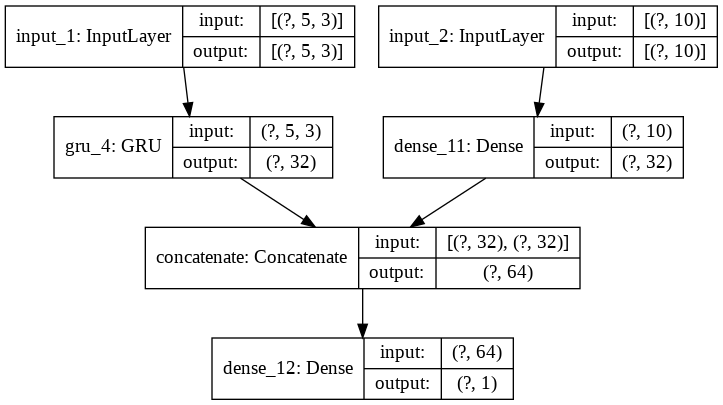

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru, layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_1 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################



multiinput_model_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_1, show_shapes=True)


#### **MULTIINPUT_MODEL_2 MODELO RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (SEM DROPOUT)**

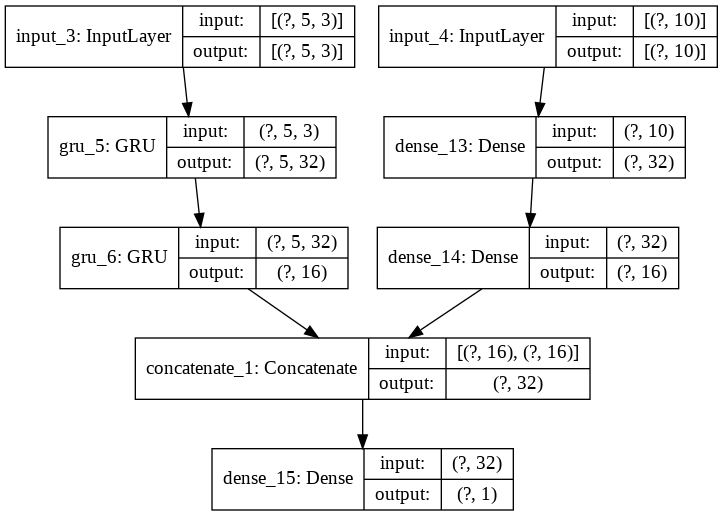

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=True)(input_layer_recorrente)

layer_gru_2 = layers.GRU(16, )(layer_gru)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_2 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################

multiinput_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_2, show_shapes=True)


#### **MULTIINPUT_MODEL_3 RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (COM DROPOUT)**


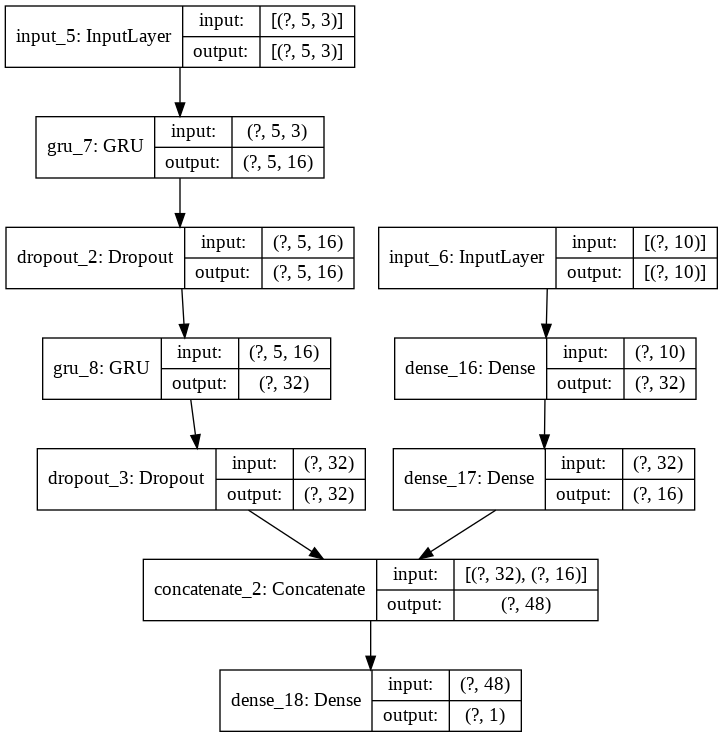

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(16, return_sequences=True)(input_layer_recorrente)
layer_dropout = layers.Dropout(0.2)(layer_gru)
layer_gru_2 = layers.GRU(32,)(layer_dropout)
layer_dropout_2 = layers.Dropout(0.2)(layer_gru_2)

# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_dropout_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_3 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################

multiinput_model_3.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_3, show_shapes=True)


#### **TREINOS MODELOS MULTINPUT**

#### **multiinput_model_1**

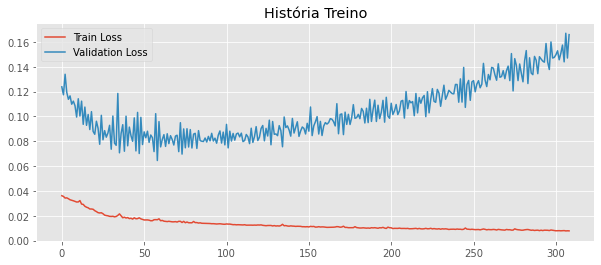

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_1.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **multiinput_model_2**

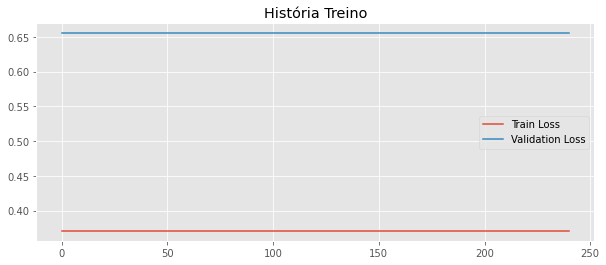

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_2.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **multiinput_model_3**

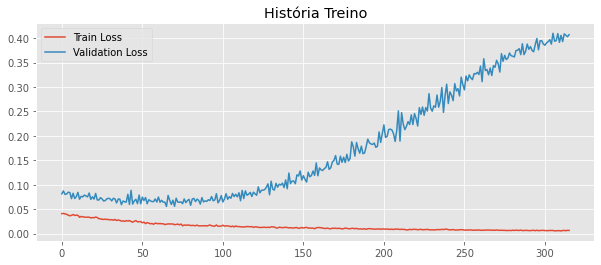

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_3.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **AVALIAÇÂO DO MODELO**

#### **multiinput_model_1**

RMSE:  130.5545289980752


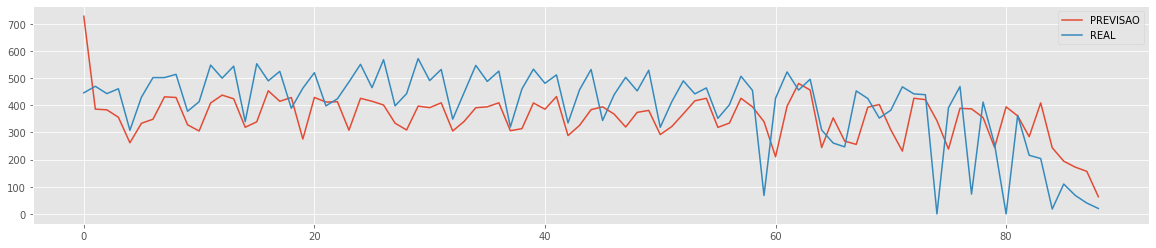

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y_mult1_val = multiinput_model_1.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y_mult1_val = scalers[feature_to_predict].inverse_transform(pred_y_mult1_val)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y_mult1_val)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y_mult1_val, label='PREVISAO')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.5199376239440452 Pi (p) :1.7722949772690097e-07


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE = 130.5545289980752
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 31683.959938049316
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6616.145660400391
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2745.105598449707
ERRO ABSOLUTO MÉDIO = 105.18259841404604
ERRO ABSOLUTO PERCENTUAL MÉDIO = 50.73826453451525%


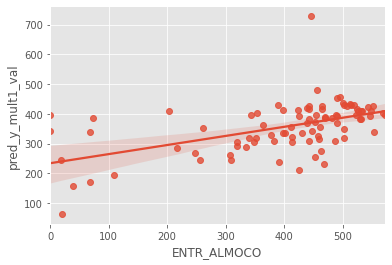

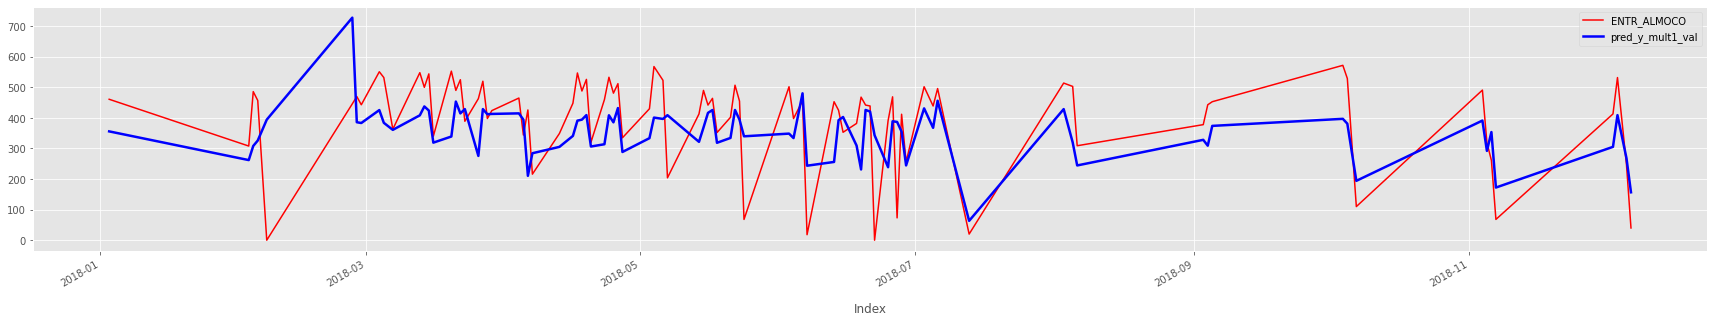

(0.5199376239440452,
 1.7722949772690097e-07,
 130.5545289980752,
 50.73826453451525,
 -6616.145660400391,
 2745.105598449707)

In [ ]:
df_val['pred_y_mult1_val'] = pred_y_mult1_val

avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'pred_y_mult1_val',df_models_metrics)

#### **multiinput_model_2**

RMSE:  416.076915966267


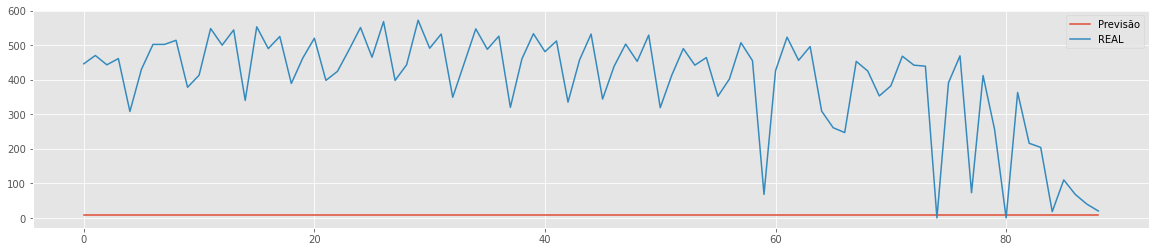

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y_mult2_val = multiinput_model_2.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y_mult2_val = scalers[feature_to_predict].inverse_transform(pred_y_mult2_val)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y_mult2_val)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y_mult2_val, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): nan Pi (p) :nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


RMSE = 416.076915966267
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 801.0
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -34772.0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 18.0
ERRO ABSOLUTO MÉDIO = 390.8988764044944
ERRO ABSOLUTO PERCENTUAL MÉDIO = 93.97356164385546%


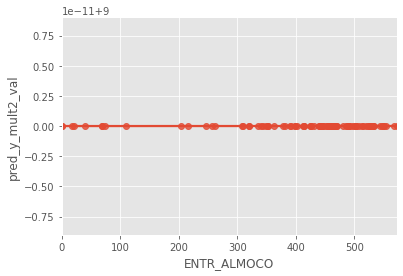

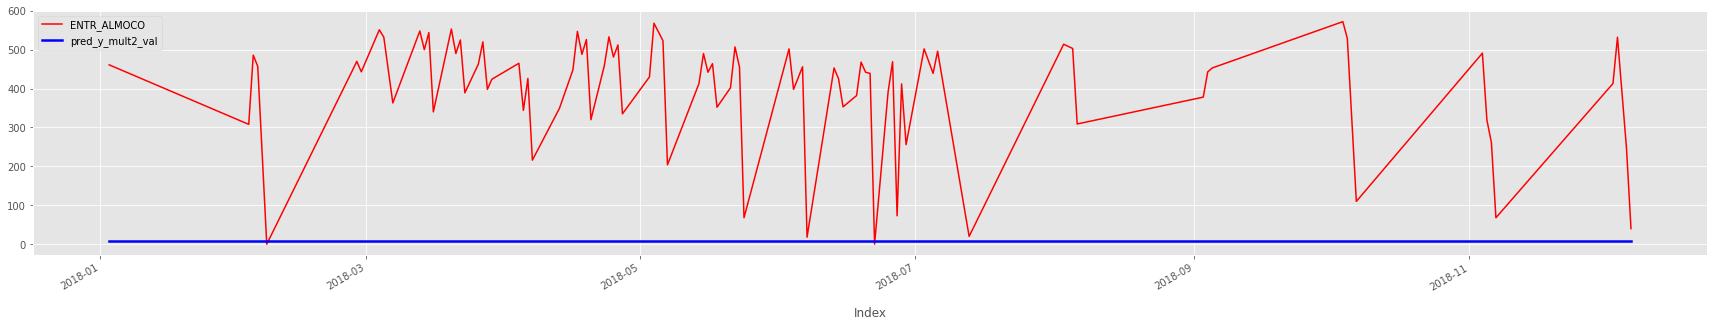

(nan, nan, 416.076915966267, 93.97356164385546, -34772.0, 18.0)

In [ ]:
df_val['pred_y_mult2_val'] = pred_y_mult2_val

avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'pred_y_mult2_val', df_models_metrics)

#### **multiinput_model_3**

RMSE:  121.23697420004763


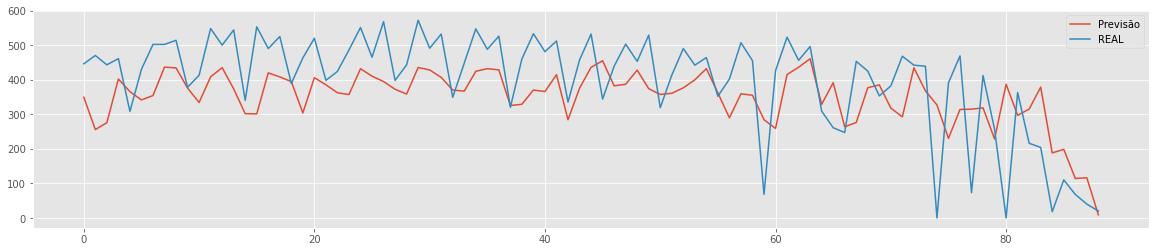

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y_mult3_val = multiinput_model_3.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y_mult3_val = scalers[feature_to_predict].inverse_transform(pred_y_mult3_val)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y_mult3_val)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y_mult3_val, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CORRELAÇÃO (r): 0.6390559490587993 Pi (p) :1.59239176122901e-11
RMSE = 121.23697420004763
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 31276.794555664062
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6550.483489990234
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2272.278045654297
ERRO ABSOLUTO MÉDIO = 99.13215208589361
ERRO ABSOLUTO PERCENTUAL MÉDIO = 40.92611492635389%


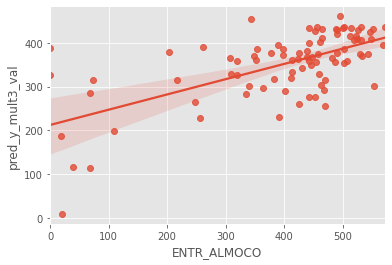

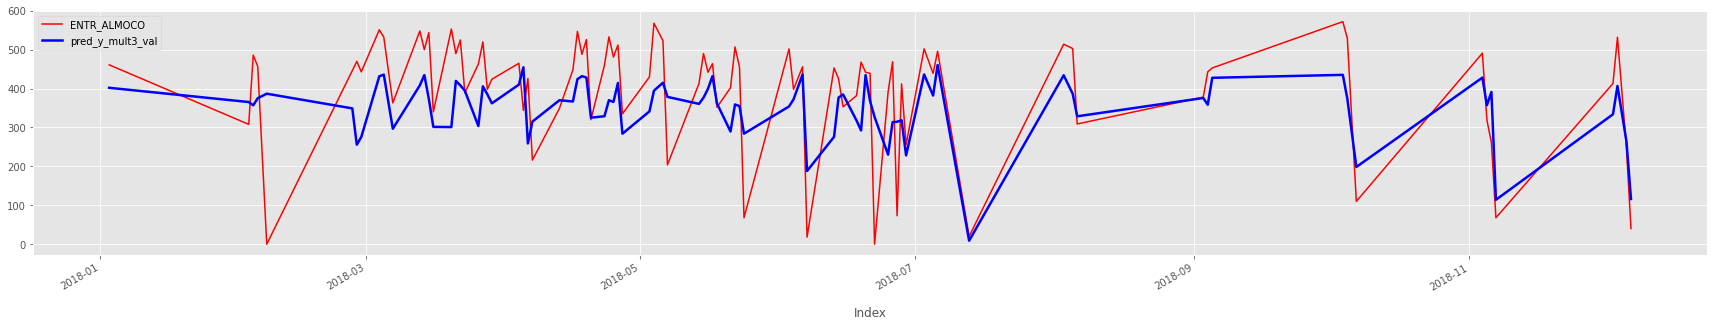

(0.6390559490587993,
 1.59239176122901e-11,
 121.23697420004763,
 40.92611492635389,
 -6550.483489990234,
 2272.278045654297)

In [ ]:
df_val['pred_y_mult3_val'] = pred_y_mult3_val

avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'pred_y_mult3_val', df_models_metrics)

# RESULTADOS DAS AVALIAÇÕES


*   TOTAL PROJETADO
*   TOTAL CONSUMIDO
*   TOTAL SUBPROJETADO
*   TOTAL SUPER PROJETADO
*   ERRO ABSOLUTO MEDIO
*   ERRO PERCENTUAL MEDIO



In [ ]:
df_models_metrics

parameters  MLP1_predictions  ...  pred_y_mult2_val  pred_y_mult3_val
0       TOTAL_PROJETADAS      30203.194660  ...        801.000000      31276.794556
1       TOTAL_CONSUMIDAS      35555.000000  ...      35555.000000      35555.000000
2    TOTAL_SUBPROJETADAS      -7427.465755  ...     -34772.000000      -6550.483490
3  TOTAL_SUPERPROJETADAS       2075.660416  ...         18.000000       2272.278046
4         ERRO_ABS_MEDIO        106.776699  ...        390.898876         99.132152
5     ERRO_ABS_PER_MEDIO         42.606733  ...         93.973562         40.926115

[6 rows x 9 columns]

# 
pred_y_rnn_unique_1_val 
pred_y_mult1_val

# REDEFINIÇÃO / TREINO E REAVALIAÇÃO DO rnn_unique_1

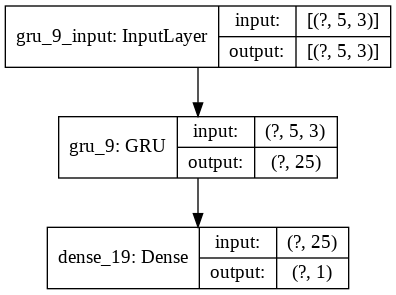

In [ ]:
#model_rnn_unique_1_new
###################### modelo RNN com uma única camada 
model_rnn_unique_1_new = keras.Sequential()
num_units = 25 # ajustavel
model_rnn_unique_1_new.add(layers.GRU(num_units, input_shape=(num_lags, num_features),))
model_rnn_unique_1_new.add(layers.Dense(num_output, activation='linear'))
model_rnn_unique_1_new.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_rnn_unique_1_new, show_shapes=True)
######################


(243, 5, 3) (243,)


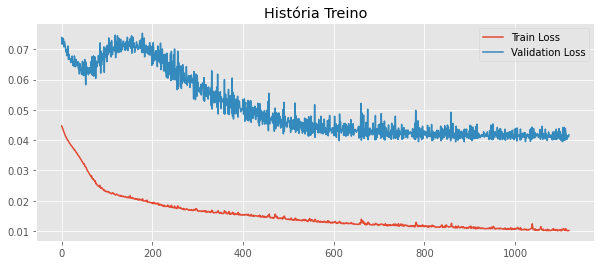

In [ ]:
#model_rnn_unique_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_rnn_unique_1_new.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

RMSE:  105.14869070560918


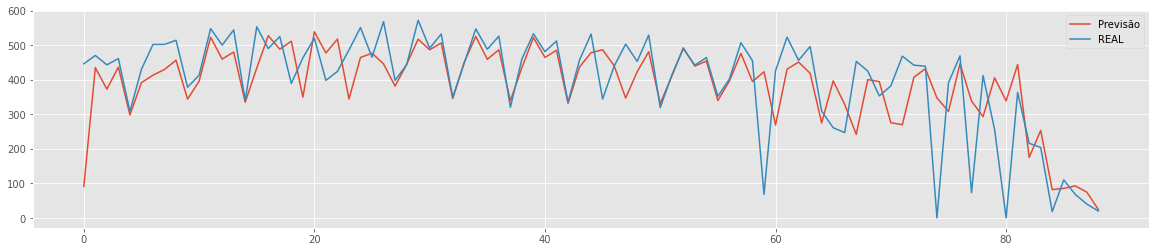

In [ ]:
#model_rnn_unique_1
pred_y_rnn_unique_1_new = model_rnn_unique_1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y_rnn_unique_1_new = scalers[feature_to_predict].inverse_transform(pred_y_rnn_unique_1_new)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y_rnn_unique_1_new)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y_rnn_unique_1_new, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.6921205269315444 Pi (p) :5.846776979938259e-14


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE = 105.14869070560918
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 34557.803411483765
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3511.952590942383
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2514.7560024261475
ERRO ABSOLUTO MÉDIO = 67.71582689178123
ERRO ABSOLUTO PERCENTUAL MÉDIO = 28.133306553738013%


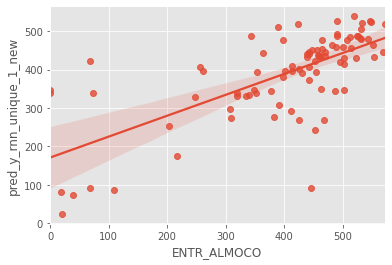

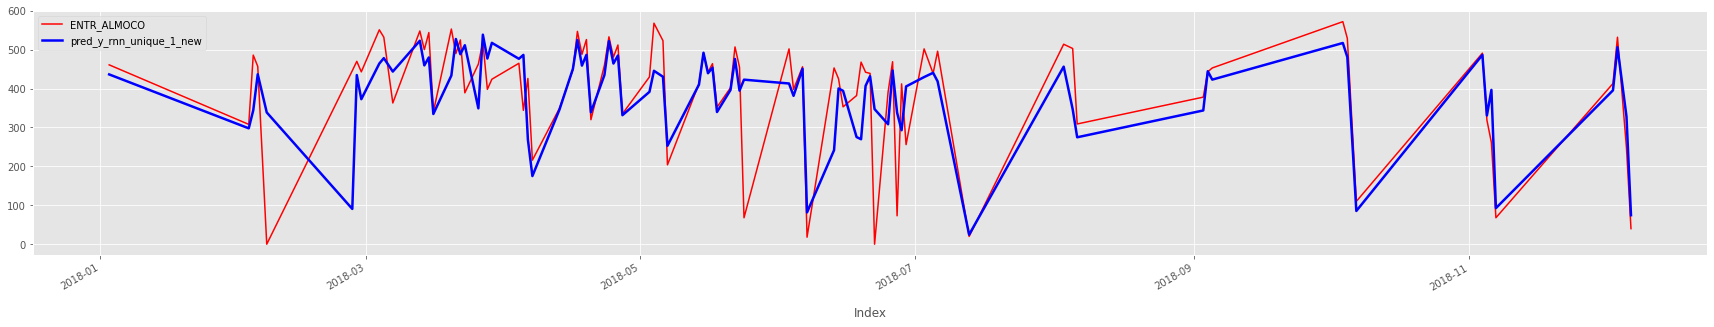

(0.6921205269315444,
 5.846776979938259e-14,
 105.14869070560918,
 28.133306553738013,
 -3511.952590942383,
 2514.7560024261475)

In [ ]:
df_val['pred_y_rnn_unique_1_new'] = pred_y_rnn_unique_1_new
avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'pred_y_rnn_unique_1_new',df_models_metrics)

# REDEFINIÇÃO / TREINO E REAVALIAÇÃO DO multiinput_model_1

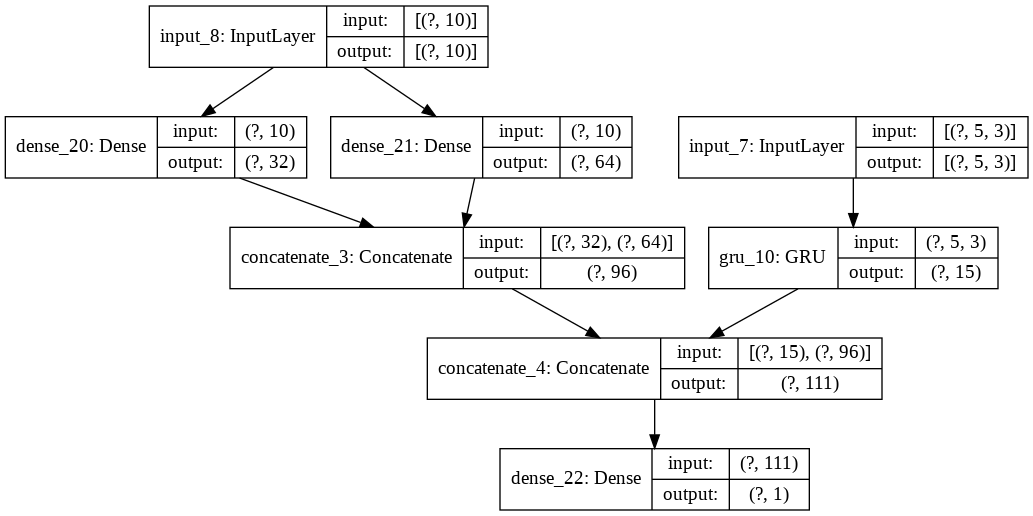

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(15, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense1 = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense2 = layers.Dense(64, activation='relu')(input_layer_dense)
layer_dense = layers.concatenate([layer_dense1, layer_dense2])
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru , layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_1_new = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################

multiinput_model_1_new.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_1_new, show_shapes=True)

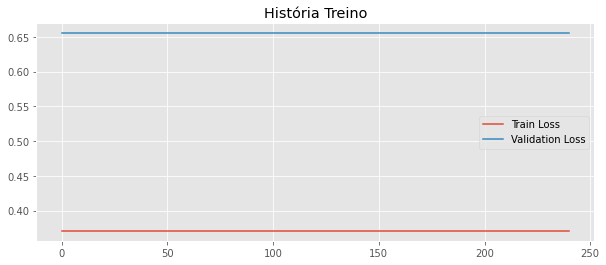

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_1_new.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

RMSE:  416.076915966267


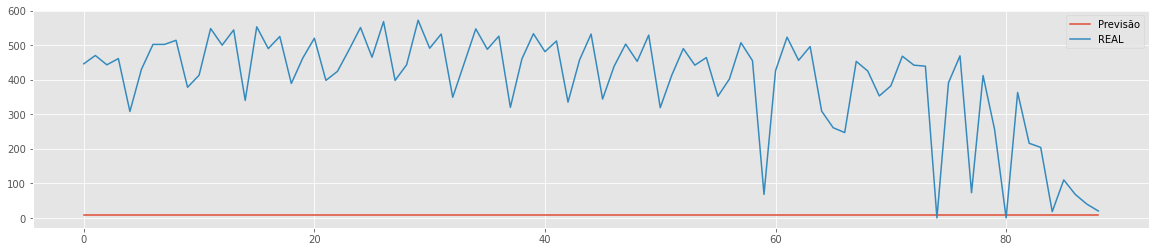

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y_multiinput_model_1_new = multiinput_model_1_new.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y_multiinput_model_1_new = scalers[feature_to_predict].inverse_transform(pred_y_multiinput_model_1_new)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y_multiinput_model_1_new)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y_multiinput_model_1_new, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): nan Pi (p) :nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


RMSE = 416.076915966267
TOTAL DE REFEIÇÕES PROJETADAS = 89 : 801.0
TOTAL DE REFEIÇÕES CONSUMIDAS = 89 : 35555
TOTAL DE REFEIÇÕES SUB PROJETADAS = -34772.0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 18.0
ERRO ABSOLUTO MÉDIO = 390.8988764044944
ERRO ABSOLUTO PERCENTUAL MÉDIO = 93.97356164385546%


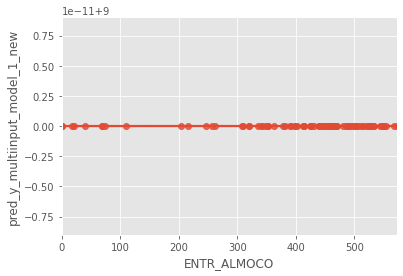

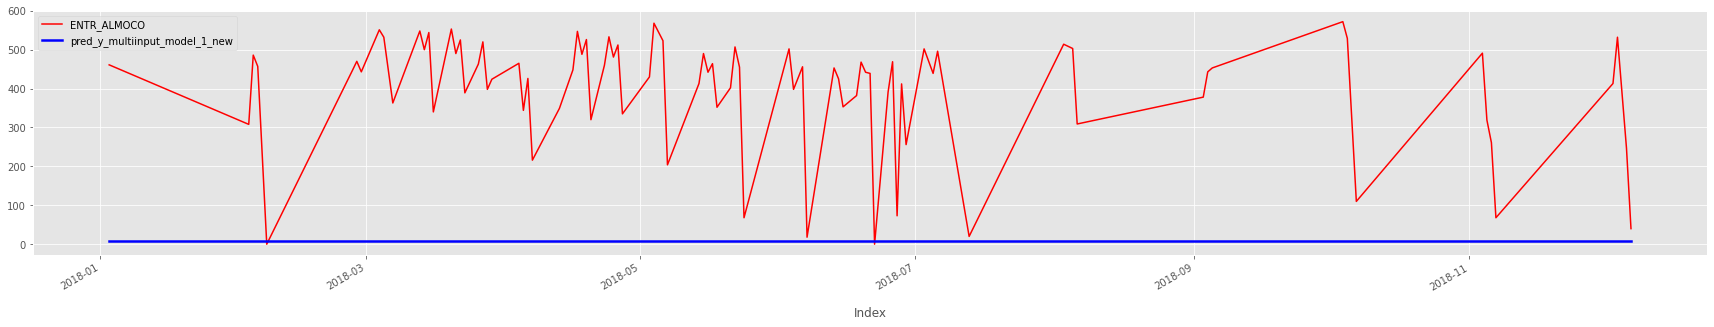

(nan, nan, 416.076915966267, 93.97356164385546, -34772.0, 18.0)

In [ ]:
df_val['pred_y_multiinput_model_1_new'] = pred_y_multiinput_model_1_new
avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'pred_y_multiinput_model_1_new',df_models_metrics)

In [ ]:
df_models_metrics

parameters  ...  pred_y_multiinput_model_1_new
0       TOTAL_PROJETADAS  ...                     801.000000
1       TOTAL_CONSUMIDAS  ...                   35555.000000
2    TOTAL_SUBPROJETADAS  ...                  -34772.000000
3  TOTAL_SUPERPROJETADAS  ...                      18.000000
4         ERRO_ABS_MEDIO  ...                     390.898876
5     ERRO_ABS_PER_MEDIO  ...                      93.973562

[6 rows x 11 columns]

# **TESTE - FINAL**

#### **MODELO SÓ COM FEATURES TEMPORAIS**
model_rnn_unique_1
model_rnn_unique_2
model_mlp_unique_2

#### MODELO REDEFINIDO

RMSE:  112.86969784300742


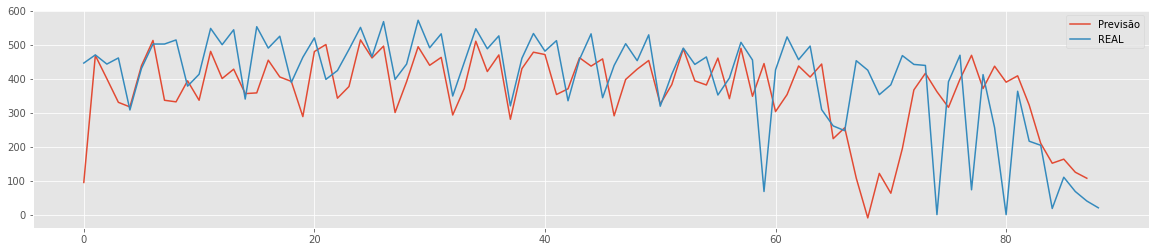

In [ ]:
#model_rnn_unique_1
x_test = scaled_test_x
pred_rnn_unique_1_new_final = model_rnn_unique_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_rnn_unique_1_new_final = scalers[feature_to_predict].inverse_transform(pred_rnn_unique_1_new_final)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(test_y, pred_rnn_unique_1_new_final)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_rnn_unique_1_new_final, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.572829398757002 Pi (p) :5.48256484733928e-09
RMSE = 112.86969784300742
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 32120.683488845825
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3380.373167037964
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3539.056655883789
ERRO ABSOLUTO MÉDIO = 78.62988435138355
ERRO ABSOLUTO PERCENTUAL MÉDIO = 81.94234690892297%


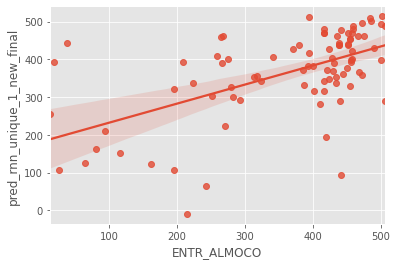

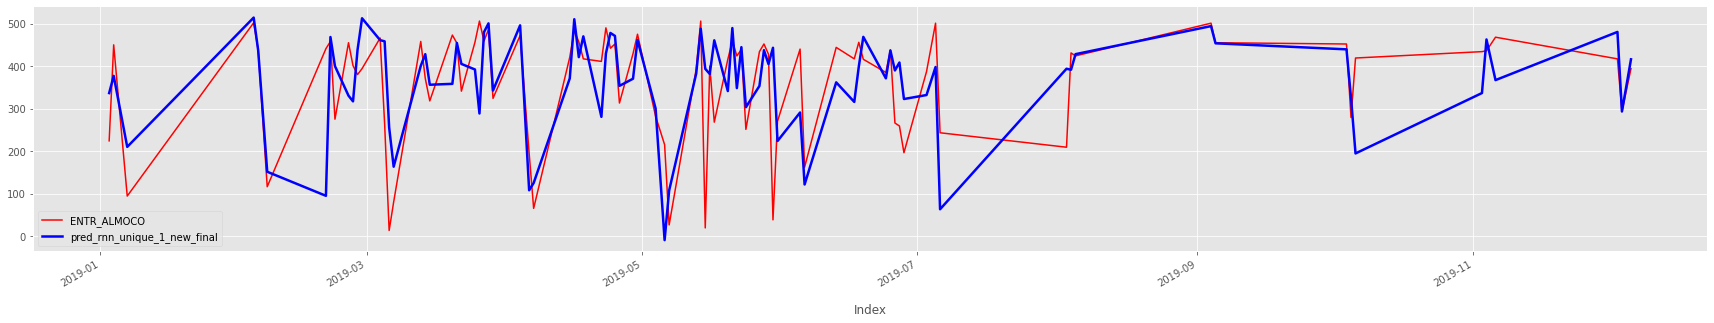

(0.572829398757002,
 5.48256484733928e-09,
 112.86969784300742,
 81.94234690892297,
 -3380.373167037964,
 3539.056655883789)

In [ ]:
df_test['pred_rnn_unique_1_new_final'] = pred_rnn_unique_1_new_final
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'pred_rnn_unique_1_new_final',df_models_metrics)

#### **model_rnn_unique_1**

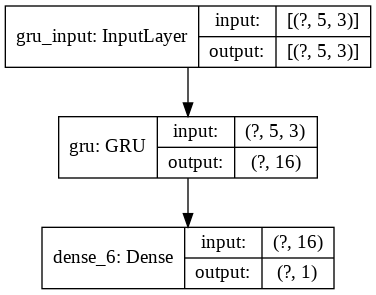

In [ ]:
keras.utils.plot_model(model_rnn_unique_1, show_shapes=True)

RMSE:  112.86969784300742


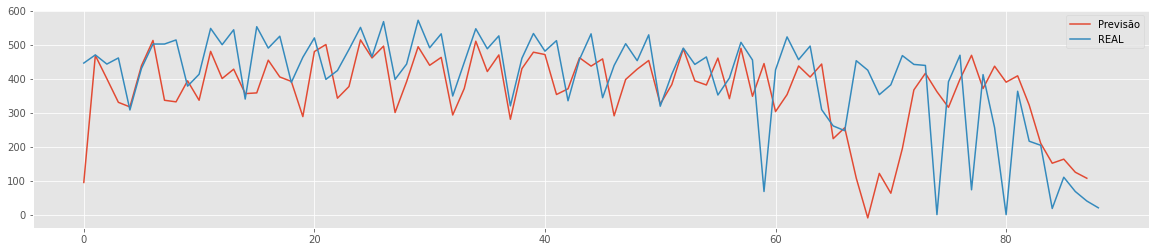

In [ ]:

x_test = scaled_test_x
pred_y = model_rnn_unique_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.572829398757002 Pi (p) :5.48256484733928e-09
RMSE = 112.86969784300742
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 32120.683488845825
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3380.373167037964
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3539.056655883789
ERRO ABSOLUTO MÉDIO = 78.62988435138355
ERRO ABSOLUTO PERCENTUAL MÉDIO = 81.94234690892297%


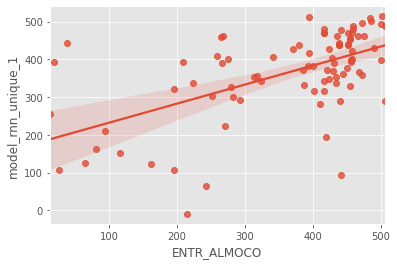

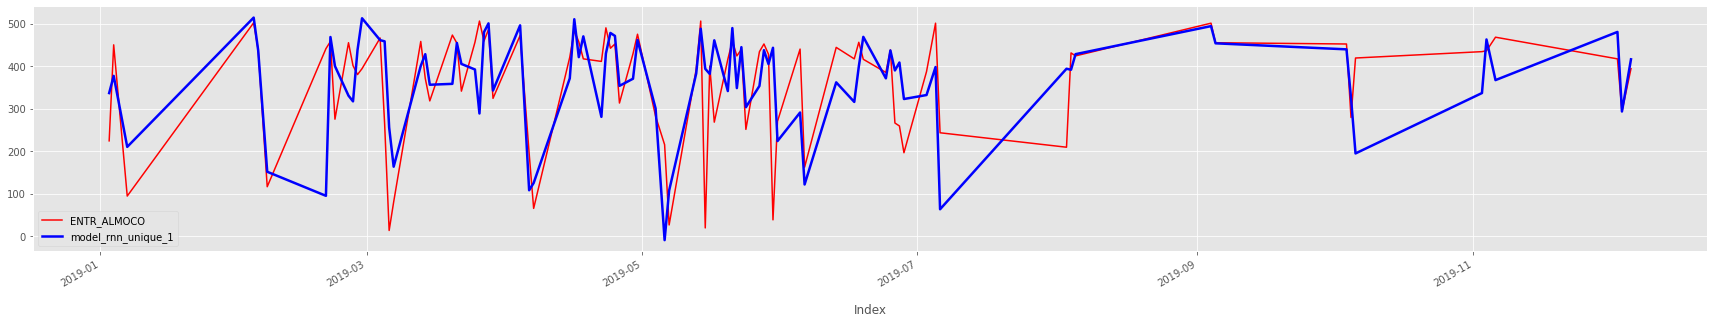

(0.572829398757002,
 5.48256484733928e-09,
 112.86969784300742,
 81.94234690892297,
 -3380.373167037964,
 3539.056655883789)

In [ ]:
df_test['model_rnn_unique_1'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'model_rnn_unique_1',df_models_metrics)

#### **model_rnn_unique_2**

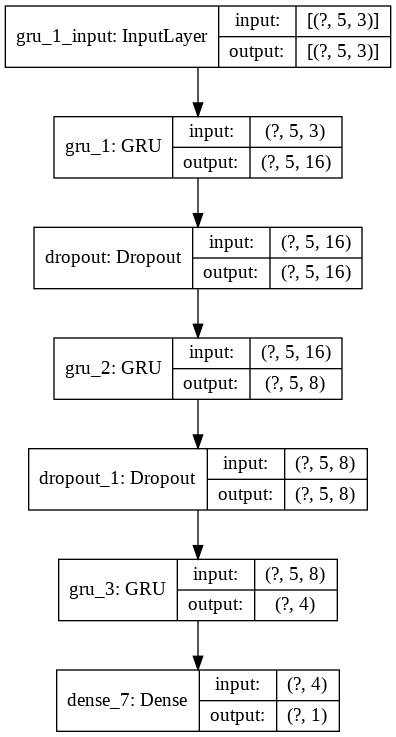

In [ ]:
keras.utils.plot_model(model_rnn_unique_2, show_shapes=True)

RMSE:  116.81862065324059


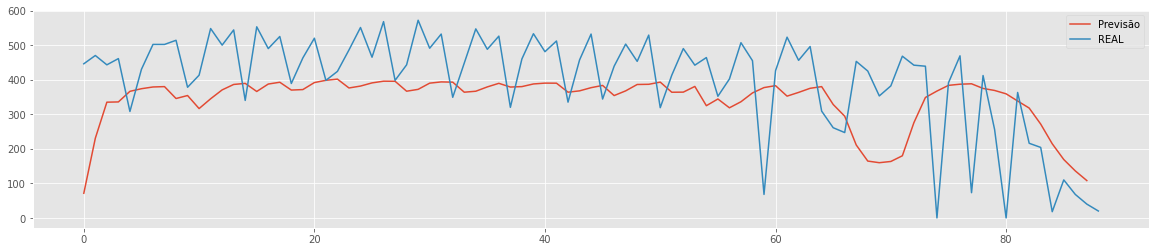

In [ ]:
x_test = scaled_test_x
pred_y = model_rnn_unique_2.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.4657377251880358 Pi (p) :4.817701652023592e-06
RMSE = 116.81862065324059
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 30048.129180908203
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5093.261291503906
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3179.3904724121094
ERRO ABSOLUTO MÉDIO = 94.00740640813655
ERRO ABSOLUTO PERCENTUAL MÉDIO = 86.17364306401743%


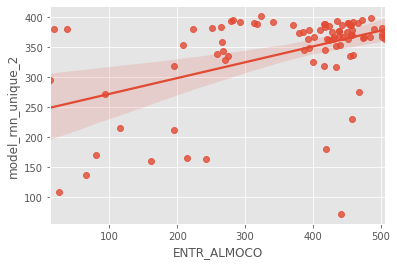

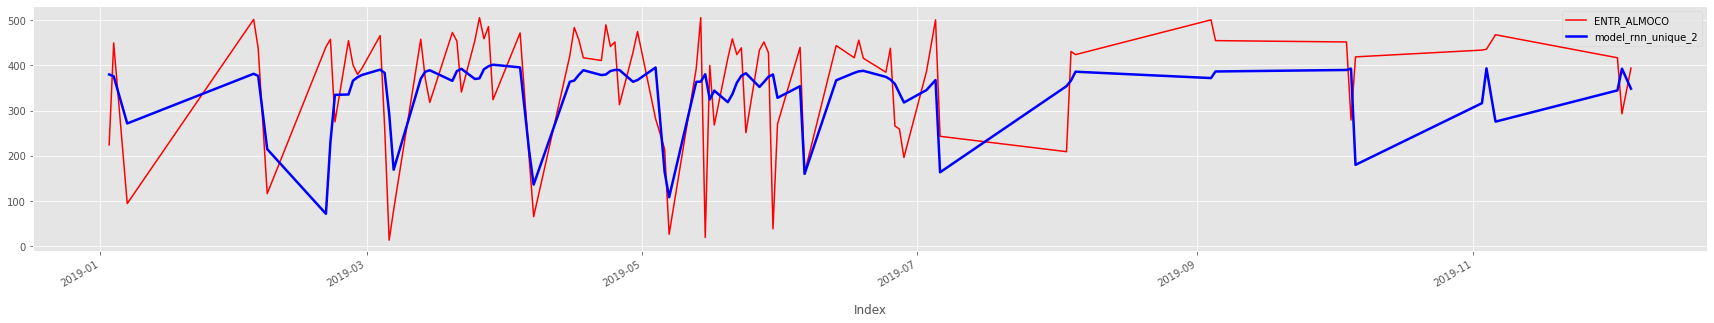

(0.4657377251880358,
 4.817701652023592e-06,
 116.81862065324059,
 86.17364306401743,
 -5093.261291503906,
 3179.3904724121094)

In [ ]:
df_test['model_rnn_unique_2'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'model_rnn_unique_2',df_models_metrics)

#### **model_mlp_unique_1**

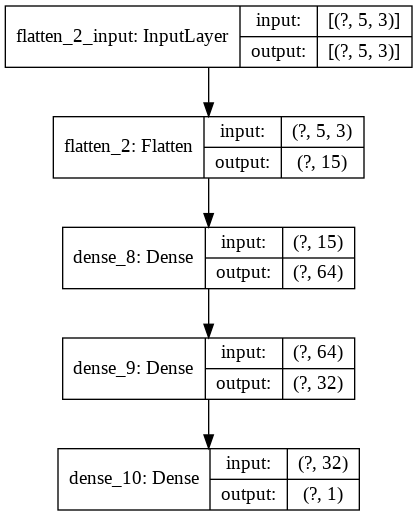

In [ ]:
keras.utils.plot_model(model_mlp_unique_1, show_shapes=True)

RMSE:  124.40695812617419


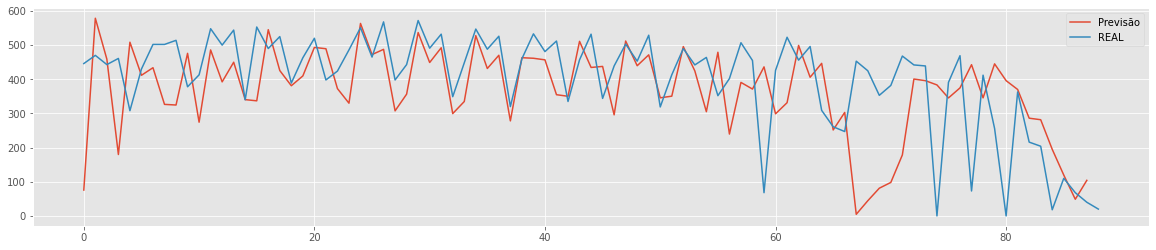

In [ ]:
x_test = scaled_test_x
pred_y = model_mlp_unique_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.5267594264742376 Pi (p) :1.350341047474119e-07
RMSE = 124.40695812617419
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 32414.847375392914
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -3684.259687900543
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 4137.107063293457
ERRO ABSOLUTO MÉDIO = 88.87916762720455
ERRO ABSOLUTO PERCENTUAL MÉDIO = 90.3673918437372%


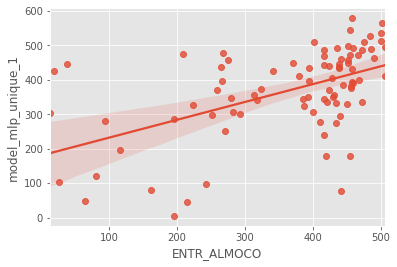

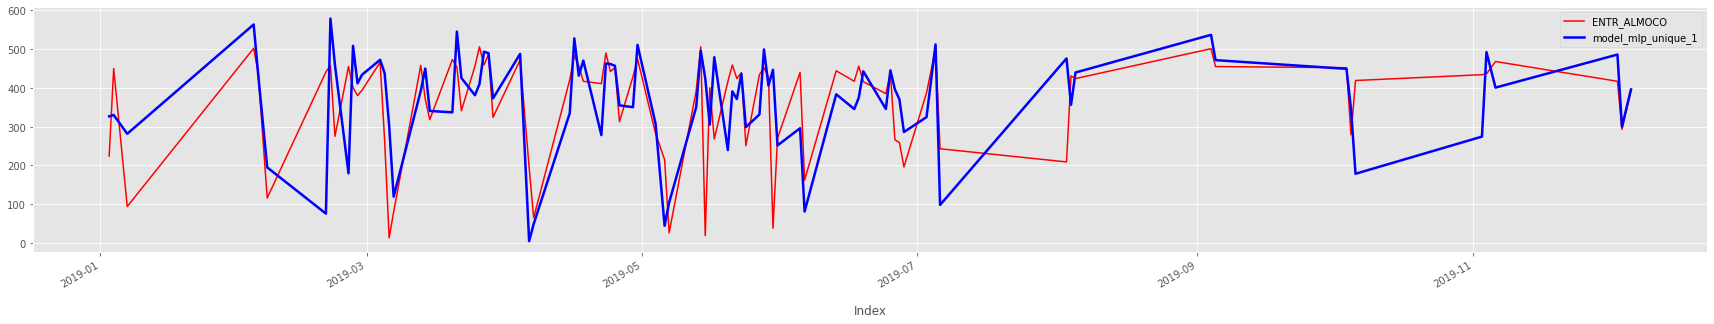

(0.5267594264742376,
 1.350341047474119e-07,
 124.40695812617419,
 90.3673918437372,
 -3684.259687900543,
 4137.107063293457)

In [ ]:
df_test['model_mlp_unique_1'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'model_mlp_unique_1',df_models_metrics)

#### **MULTI INPUT MODELS**
multiinput_model_1
multiinput_model_2
multiinput_model_3

#### **MULTI INPUT REDEFINIDO**

RMSE:  376.90989398239225


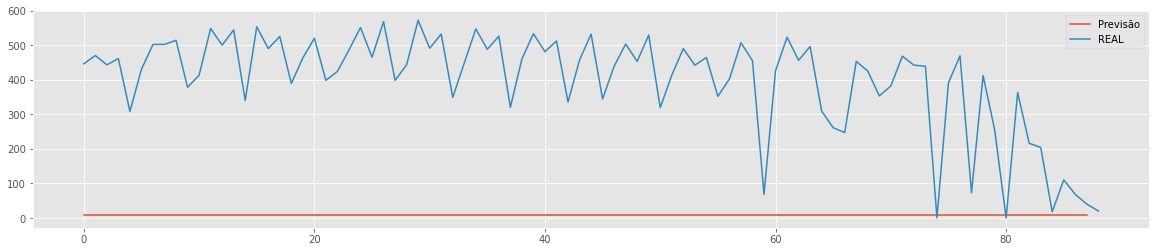

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_1_new.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): nan Pi (p) :nan


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


RMSE = 376.90989398239225
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 792.0
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -31170.0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 0
ERRO ABSOLUTO MÉDIO = 354.20454545454544
ERRO ABSOLUTO PERCENTUAL MÉDIO = 95.29992605883741%


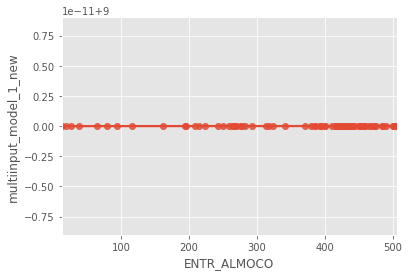

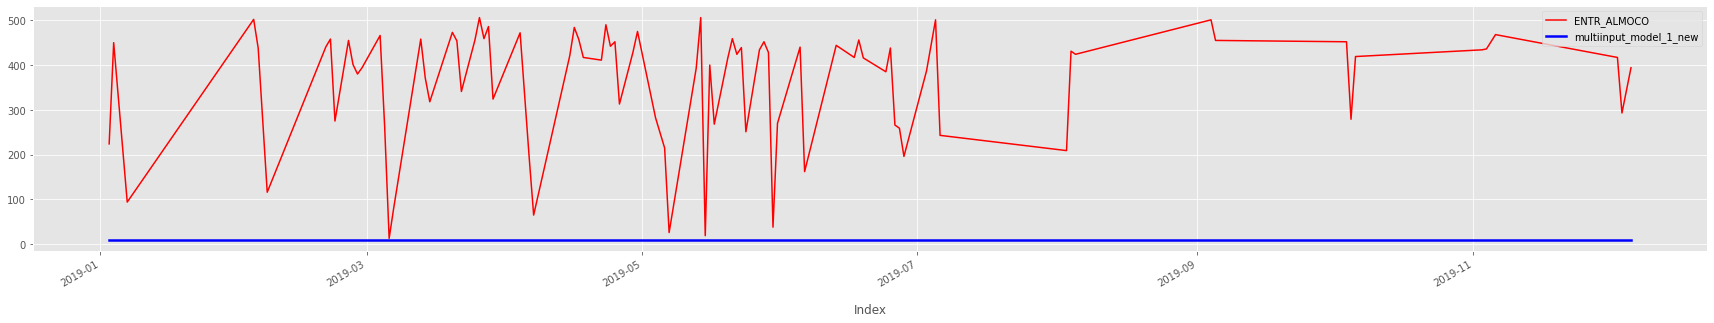

(nan, nan, 376.90989398239225, 95.29992605883741, -31170.0, 0)

In [ ]:
df_test['multiinput_model_1_new'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'multiinput_model_1_new',df_models_metrics)

#### **multiinput_model_1**

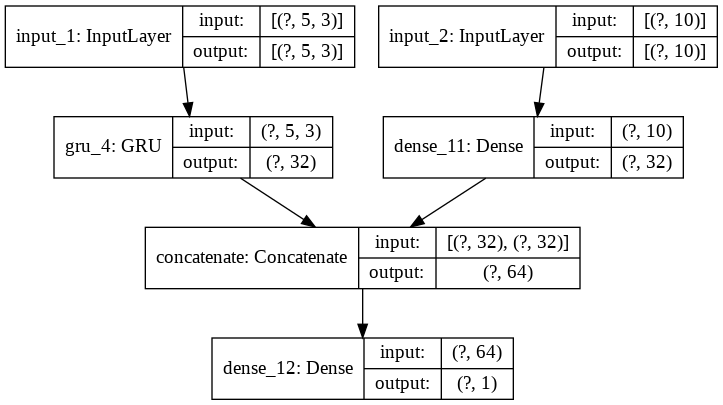

In [ ]:
keras.utils.plot_model(multiinput_model_1, show_shapes=True)

RMSE:  112.61476275584135


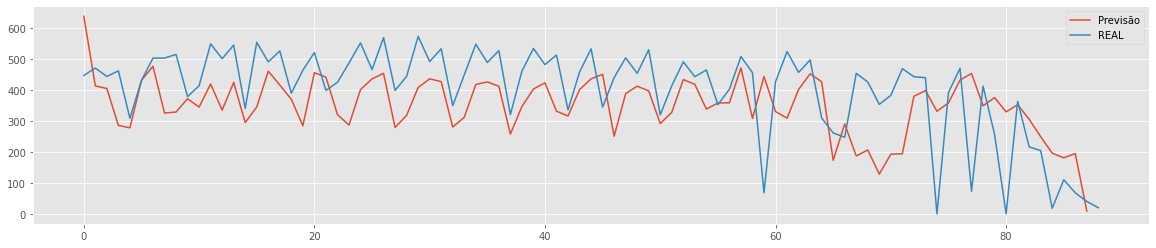

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.531980991162302 Pi (p) :9.61679178431113e-08
RMSE = 112.61476275584135
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 30856.885803222656
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4215.4727783203125
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3110.3585815429688
ERRO ABSOLUTO MÉDIO = 83.24808363481002
ERRO ABSOLUTO PERCENTUAL MÉDIO = 84.33445555681514%


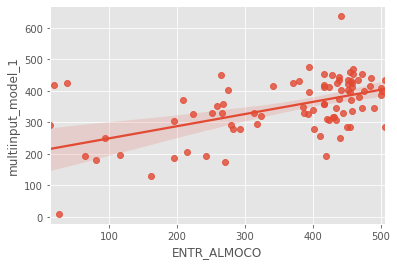

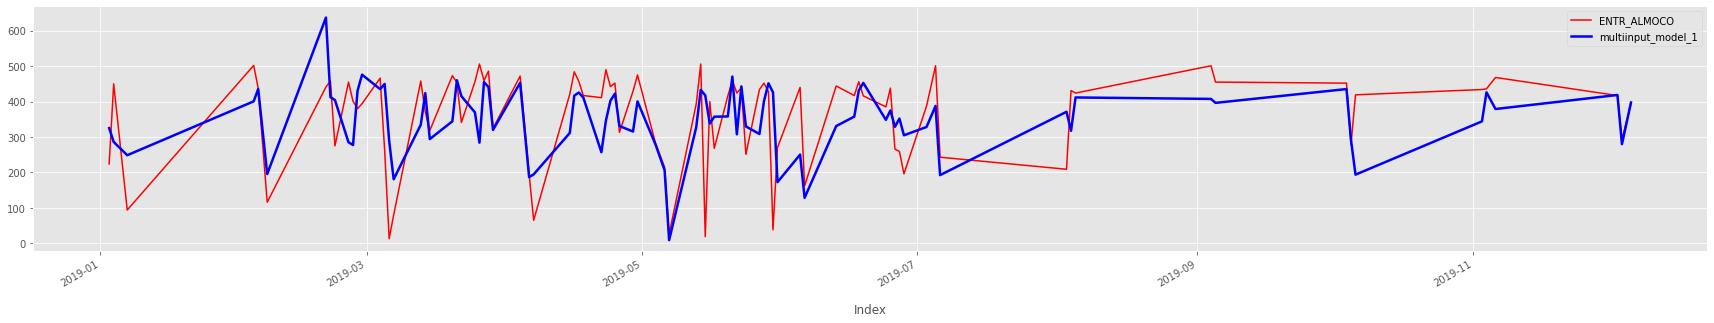

(0.531980991162302,
 9.61679178431113e-08,
 112.61476275584135,
 84.33445555681514,
 -4215.4727783203125,
 3110.3585815429688)

In [ ]:
df_test['multiinput_model_1'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'multiinput_model_1',df_models_metrics)

#### **multiinput_model2**

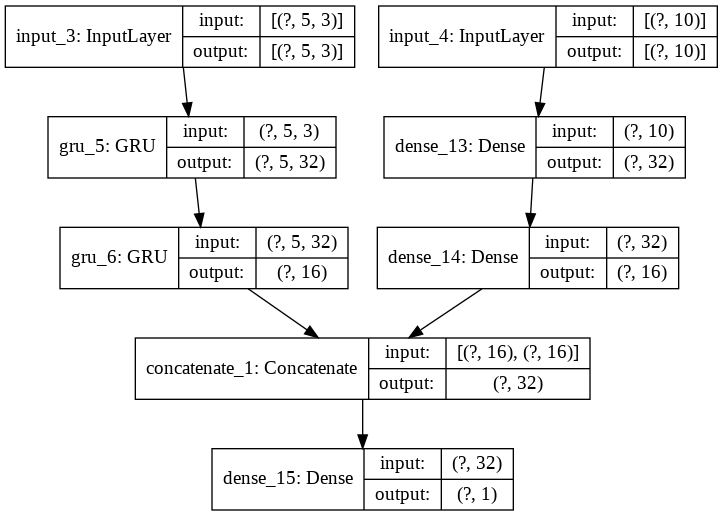

In [ ]:
keras.utils.plot_model(multiinput_model_2, show_shapes=True)

RMSE:  376.90989398239225


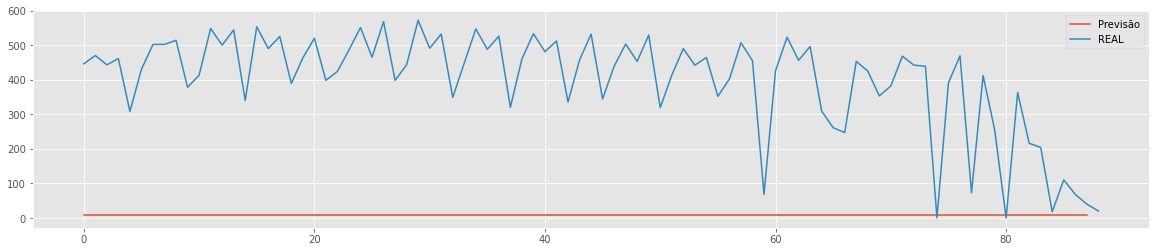

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_2.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)

# 
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CORRELAÇÃO (r): nan Pi (p) :nan
RMSE = 376.90989398239225
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 792.0
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -31170.0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 0
ERRO ABSOLUTO MÉDIO = 354.20454545454544
ERRO ABSOLUTO PERCENTUAL MÉDIO = 95.29992605883741%


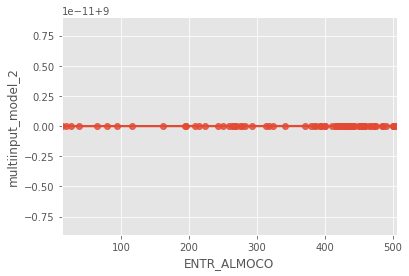

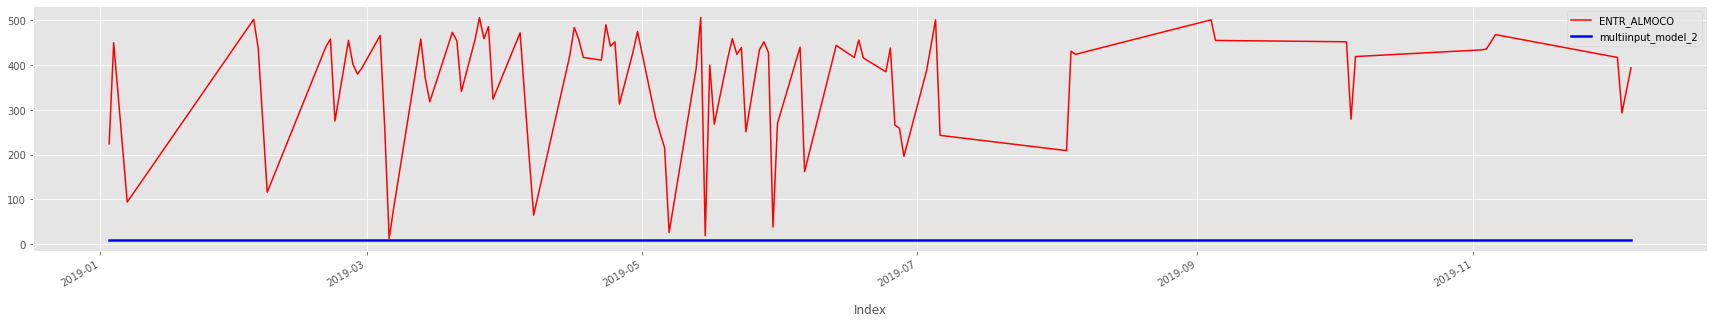

(nan, nan, 376.90989398239225, 95.29992605883741, -31170.0, 0)

In [ ]:
df_test['multiinput_model_2'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'multiinput_model_2',df_models_metrics)

#### **multiinput_model_3**

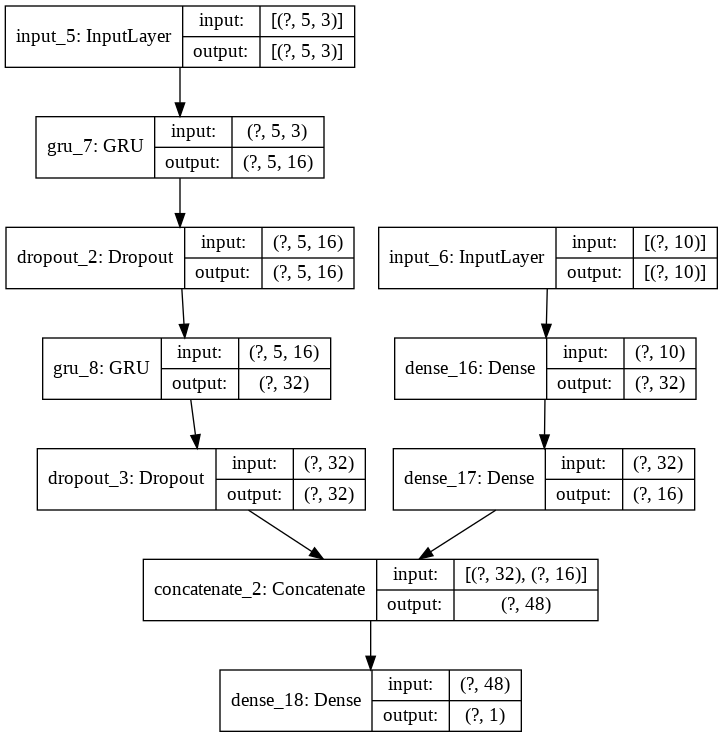

In [ ]:
keras.utils.plot_model(multiinput_model_3, show_shapes=True)

RMSE:  116.61214983572425


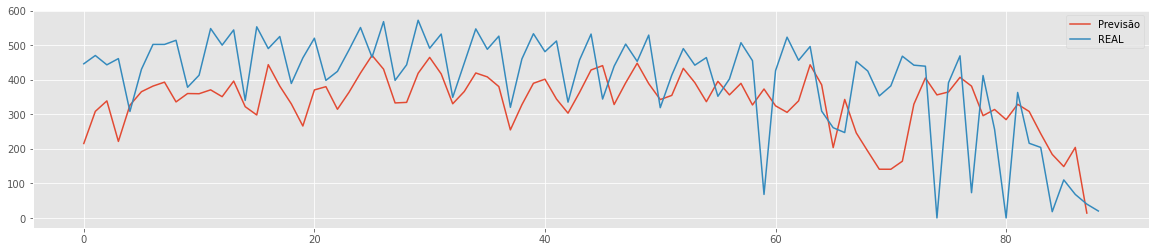

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_3.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

CORRELAÇÃO (r): 0.49207508468100386 Pi (p) :1.1206851266205488e-06
RMSE = 116.61214983572425
TOTAL DE REFEIÇÕES PROJETADAS = 88 : 29682.081912994385
TOTAL DE REFEIÇÕES CONSUMIDAS = 88 : 31962
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5085.138988494873
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 2805.220901489258
ERRO ABSOLUTO MÉDIO = 89.6631805680015
ERRO ABSOLUTO PERCENTUAL MÉDIO = 87.28271925379154%


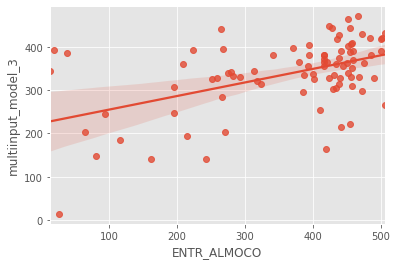

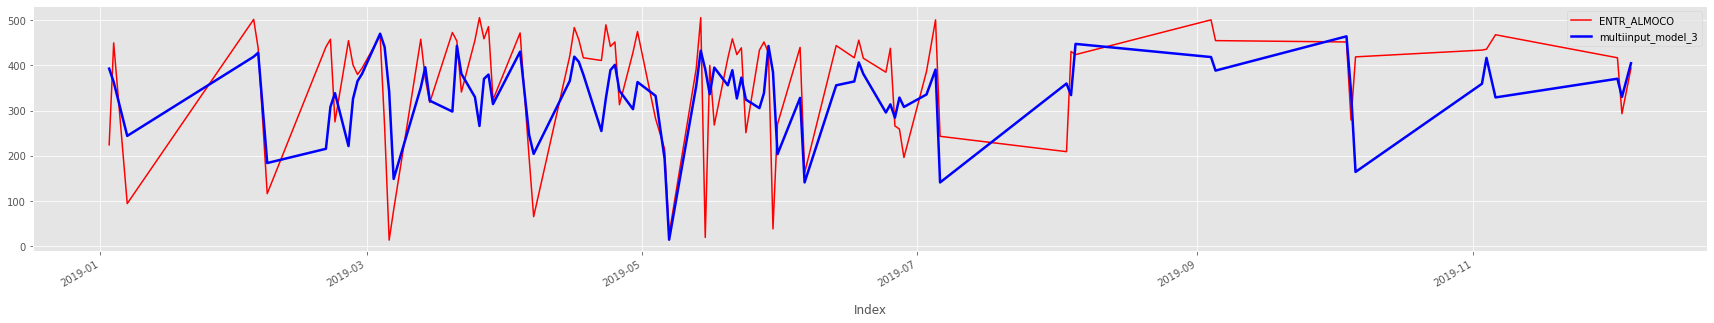

(0.49207508468100386,
 1.1206851266205488e-06,
 116.61214983572425,
 87.28271925379154,
 -5085.138988494873,
 2805.220901489258)

In [ ]:
df_test['multiinput_model_3'] = pred_y
avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'multiinput_model_3',df_models_metrics)

In [ ]:
df_models_metrics

parameters  ...  multiinput_model_3
0       TOTAL_PROJETADAS  ...        29682.081913
1       TOTAL_CONSUMIDAS  ...        31962.000000
2    TOTAL_SUBPROJETADAS  ...        -5085.138988
3  TOTAL_SUPERPROJETADAS  ...         2805.220901
4         ERRO_ABS_MEDIO  ...           89.663181
5     ERRO_ABS_PER_MEDIO  ...           87.282719

[6 rows x 19 columns]

In [ ]:
df_models_metrics2['parameters'] =  ['TOTAL_PROJETADAS','TOTAL_CONSUMIDAS','TOTAL_SUBPROJETADAS','TOTAL_SUPERPROJETADAS','ERRO_ABS_MEDIO','ERRO_ABS_PER_MEDIO']

In [ ]:
parameters = df_models_metrics2['parameters']
df_models_metrics2.drop(labels=['parameters'], axis=1,inplace = True)
df_models_metrics2.insert(0, 'parameters', parameters)
df_models_metrics2

parameters  RU_ALMOCO_PRED  ...         VENTO       UMIDADE
0       TOTAL_PROJETADAS    41351.000000  ...    601.900000  17575.000000
1       TOTAL_CONSUMIDAS    31962.000000  ...  69544.000000  69544.000000
2    TOTAL_SUBPROJETADAS    -3650.000000  ... -68942.100000 -53770.000000
3  TOTAL_SUPERPROJETADAS    13039.000000  ...      0.000000   1801.000000
4         ERRO_ABS_MEDIO      189.647727  ...    283.712346    228.687243
5     ERRO_ABS_PER_MEDIO      167.272471  ...     97.706237    105.200796

[6 rows x 15 columns]